## Gait Video Study 
### Traditional ML algorithms on subject generalization framework 1: walking (W) to classify HOA/MS/PD strides and subjects using cross validation 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model

In [52]:
from importlib import reload
import imports 
reload(imports)
from imports import *
from split import StratifiedGroupKFold

In [53]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\MLresults\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

key cohort trial scenario         video  PID  stride_number  \
0  GVS_212_T_T1_1    HOA    BW     SLWT  GVS_212_T_T1  212              1   
1  GVS_212_T_T1_2    HOA    BW     SLWT  GVS_212_T_T1  212              2   
2  GVS_212_T_T1_3    HOA    BW     SLWT  GVS_212_T_T1  212              3   
3  GVS_212_T_T1_4    HOA    BW     SLWT  GVS_212_T_T1  212              4   
4  GVS_212_T_T1_5    HOA    BW     SLWT  GVS_212_T_T1  212              5   

   frame_count  label  right hip-x-CoV  ...  ankle-z-asymmetry  \
0           46      0         0.046077  ...          14.426173   
1           39      0         0.021528  ...           1.360847   
2           56      0         0.034394  ...           1.341021   
3           53      0         0.028511  ...           2.375934   
4           44      0         0.025213  ...           8.525816   

   heel-x-asymmetry  heel-y-asymmetry  heel-z-asymmetry  toe 1-x-asymmetry  \
0          3.407379         10.662441          0.830365           0.502570   
1          5.155307         11.363806          4.333776           1.025647   
2          8.625363          7.159495          3.366152           1.759968   
3          6.728268          0.098235          0.999027           0.541911   
4          1.775282          0.033210          9.166863           1.354601   

   toe 1-y-asymmetry  toe 1-z-asymmetry  toe 2-x-asymmetry  toe 2-y-asymmetry  \
0          31.450487           8.644012           5.236678          31.182183   
1          28.266400           2.671081           6.678294          15.058825   
2          17.545787           5.921325           8.243491           9.578638   
3           7.843339           4.279617           0.748023          19.471731   
4           6.674183           8.479480           4.373622           0.315168   

   toe 2-z-asymmetry  
0           8.215725  
1           4.903579  
2           3.008162  
3           5.086056  
4          11.795593  

[5 rows x 99 columns]

### Utility functions 

In [54]:
def evaluate(model, test_features, yoriginal_, ypredicted_, framework, model_name):
    '''
    Arguments: trained model, test set, true and predicted labels for test set, framework and model name 
    Returns: predicted probabilities and labels for each class, stride and subject based evaluation metrics 
    Saves the csv files for stride wise predictions and subject wise predictions for confusion matrix 
    '''
    #For creating the stride wise confusion matrix, we append the true and predicted labels for strides in each fold to this 
    #test_strides_true_predicted_labels dataframe 
    test_strides_true_predicted_labels = pd.DataFrame()
    #For creating the subject wise confusion matrix, we append the true and predicted labels for subjects in each fold to this
    #test_subjects_true_predicted_labels dataframe
    test_subjects_true_predicted_labels = pd.DataFrame()
    
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':make_scorer(precision_score, average = 'macro'), \
            'recall':make_scorer(recall_score, average = 'macro'), 'f1': make_scorer(f1_score, average = 'macro'), \
           'auc': make_scorer(roc_auc_score, average = 'macro', multi_class = 'ovo', needs_proba= True)}
    
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 5
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
        temp = test_features.loc[yoriginal_[(best_index*n_folds) + (i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*n_folds) + (i)] #Predicted labels for the strides in the test set in each fold
#         print ('temp_pred', temp['pred'])
        #Appending the test strides' true and predicted label for each fold to compute stride-wise confusion matrix 
        test_strides_true_predicted_labels = test_strides_true_predicted_labels.append(temp)
        
        x = temp.groupby('PID')['pred'].value_counts().unstack()
#         print ('x', x)
        #Input for subject wise AUC is probabilities at columns [0, 1, 2]
        proportion_strides_correct = pd.DataFrame(columns = [0, 1, 2])
        probs_stride_wise = x.divide(x.sum(axis = 1), axis = 0).fillna(0)
        proportion_strides_correct[probs_stride_wise.columns] = probs_stride_wise
        proportion_strides_correct.fillna(0, inplace=True)
        proportion_strides_correct['True Label'] = test_features.groupby('PID').first()
        #Input for precision, recall and F1 score
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct[[0, 1, 2]].idxmax(axis = 1) 
        #Appending the test subjects' true and predicted label for each fold to compute subject-wise confusion matrix 
        test_subjects_true_predicted_labels = test_subjects_true_predicted_labels.append(proportion_strides_correct)          
            
        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                       average = 'macro'))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                    average = 'macro'))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                  average = 'macro'))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct[[0, 1, 2]], \
                                        multi_class = 'ovo', average= 'macro'))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)
    
    #Saving the stride and person wise true and predicted labels for calculating the 
    #stride and subject wise confusion matrix for each model
    test_strides_true_predicted_labels.to_csv(results_path+ framework + '\\stride_wise_predictions_' + \
                                      str(model_name) + '_' + framework + '.csv')
    test_subjects_true_predicted_labels.to_csv(results_path+ framework + '\\person_wise_predictions_' + \
                                      str(model_name) + '_' + framework + '.csv')
    
    return test_subjects_true_predicted_labels, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

In [55]:
def acc(y_true,y_pred):
    '''
    Returns the accuracy 
    Saves the true and predicted labels for training and test sets
    '''
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [56]:
#We do not use LDA/QDA since our features are not normally distributed 
def models(X, Y, model_name = 'random_forest', framework = 'W'):
    '''
    Arguments:
    X, Y, PID groups so that strides of each person are either in training or in testing set
    model: model_name, framework we wish to run the code for
    Returns: predicted probabilities and labels for each class, stride and subject based evaluation metrics 
    '''
    Y_ = Y['label'] #Dropping the PID
    groups_ = Y['PID']
    #We use stratified group K-fold to sample our strides data
    gkf = StratifiedGroupKFold(n_splits=5) 
    scores={'accuracy': make_scorer(acc), 'precision':make_scorer(precision_score, average = 'macro'), \
            'recall':make_scorer(recall_score, average = 'macro'), 'f1': make_scorer(f1_score, average = 'macro'), \
            'auc': make_scorer(roc_auc_score, average = 'macro', multi_class = 'ovo', needs_proba=True)}
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'randomforestclassifier__n_estimators': [40,45,50],\
       'randomforestclassifier__max_depth' : [15,20,25,None],\
       'randomforestclassifier__class_weight': [None, 'balanced'],\
       'randomforestclassifier__max_features': ['auto','sqrt','log2', None],\
       'randomforestclassifier__min_samples_leaf':[1,2,0.1,0.05]
        }
        #For z-score scaling on training and use calculated coefficients on test set
        rf_grid = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0))
        grid_search = GridSearchCV(rf_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))
        grid = {
        'adaboostclassifier__n_estimators':[50, 75, 100, 125, 150],\
        'adaboostclassifier__learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', probability=True, random_state=0))
        grid = {
        'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'gbm'): #GBM
        gbm_grid = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
        grid = {
        'gradientboostingclassifier__learning_rate':[0.15,0.1,0.05], \
        'gradientboostingclassifier__n_estimators':[50, 100, 150],\
        'gradientboostingclassifier__max_depth':[2,4,7],\
        'gradientboostingclassifier__min_samples_split':[2,4], \
        'gradientboostingclassifier__min_samples_leaf':[1,3],\
        'gradientboostingclassifier__max_features':['auto','sqrt','log2', None],\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = make_pipeline(StandardScaler(), xgboost.XGBClassifier(random_state=0))
        grid = {
            'xgbclassifier__min_child_weight': [1, 5],\
            'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 2],\
            'xgbclassifier__subsample': [0.6, 0.8, 1.0],\
            'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],\
            'xgbclassifier__max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'knn'): #KNN
        knn_grid = make_pipeline(StandardScaler(), KNeighborsClassifier())
        grid = {
            'kneighborsclassifier__n_neighbors': [1, 3, 4, 5, 10],\
            'kneighborsclassifier__p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
        #For z-score scaling on training and use calculated coefficients on test set
        grid = {'decisiontreeclassifier__min_samples_split': range(2, 50)}
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)

    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = make_pipeline(StandardScaler(), SVC(kernel = 'linear', probability=True, random_state=0)) #LinearSVC(random_state=0, probability= True))
        grid = {
            'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        lr_grid = make_pipeline(StandardScaler(), LogisticRegression())
        grid = {
            'logisticregression__random_state': [0]}
            
        grid_search = GridSearchCV(lr_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    
    if(model_name == 'mlp'):
        mlp_grid = make_pipeline(StandardScaler(), MLPClassifier(random_state = 0, activation='relu', solver='adam',\
                                                       learning_rate = 'adaptive', learning_rate_init=0.001, 
                                                        shuffle=False, max_iter = 200))
        grid = {
            'mlpclassifier__hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False)
    grid_search.fit(X, Y_, groups=groups_) #Fitting on the training set to find the optimal hyperparameters 
    test_subjects_true_predicted_labels, stride_person_metrics = evaluate(grid_search, Y, yoriginal, ypredicted, framework, model_name)
    return test_subjects_true_predicted_labels, stride_person_metrics

In [57]:
#ROC curves 
def plot_ROC(ml_model, test_set_true_predicted_labels, framework):
    '''
    Function to plot the ROC curve and confusion matrix for model given in ml_model name 
    Input: ml_models (name of models to plot the ROC for),  test_Y (true test set labels with PID), 
        predicted_probs_person (predicted test set probabilities for all 3 classes - HOA/MS/PD), framework (WtoWT / VBWtoVBWT)
    Plots and saves the ROC curve with individual class-wise plots and micro/macro average plots 
    '''
    n_classes = 3 #HOA/MS/PD
    cohort = ['HOA', 'MS', 'PD']
    ml_model_names = {'random_forest': 'RF', 'adaboost': 'AdaBoost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp':'MLP'}

    #Binarizing/getting dummies for the true labels i.e. class 1 is represented as 0, 1, 0
    test_features_binarize = pd.get_dummies(test_set_true_predicted_labels['True Label'].values)     
    sns.despine(offset=0)
    linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
    colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

    fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(6, 4.5))
    axes.plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
    # person-based prediction probabilities for class 0: HOA, 1: MS, 2: PD

    # Compute ROC curve and ROC area for each class
    tpr, fpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes): #n_classes = 3
        fpr[i], tpr[i], _ = roc_curve(test_features_binarize.iloc[:, i], test_set_true_predicted_labels.loc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        #Plotting the ROCs for the three classes separately
        axes.plot(fpr[i], tpr[i], label = cohort[i] +' ROC (AUC = '+ str(round(roc_auc[i], 3))
            +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[i], color = colors[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_features_binarize.values.ravel(),\
                                              test_set_true_predicted_labels[[0, 1, 2]].values.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #Plotting the micro average ROC 
    axes.plot(fpr["micro"], tpr["micro"], label= 'micro average ROC (AUC = '+ str(round(roc_auc["micro"], 3))
            +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[3], color = colors[3])
    
    #Compute the macro-average ROC curve and AUC value
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) # First aggregate all false positive rates
    mean_tpr = np.zeros_like(all_fpr) # Then interpolate all ROC curves at this points
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes  # Finally average it and compute AUC
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    #Macro average AUC of ROC value 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])    
    #Plotting the macro average AUC
    axes.plot(fpr["macro"], tpr["macro"], label= 'macro average ROC (AUC = '+ str(round(roc_auc["macro"], 3))
        +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[4], color = colors[4])
    
    axes.set_ylabel('True Positive Rate')
    axes.set_title('Subject generalization '+framework + ' '+ ml_model_names[ml_model])
    plt.legend()
    # axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

    axes.set_xlabel('False Positive Rate')
    plt.tight_layout()
    plt.savefig(results_path + framework+'\\ROC_subject_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
    plt.show()
    
    #Plotting and saving the subject wise confusion matrix 
    plt.figure()
    confusion_matrix = pd.crosstab(test_set_true_predicted_labels['True Label'], test_set_true_predicted_labels['Predicted Label'], \
                                   rownames=['Actual'], colnames=['Predicted'], margins = True)
    sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
    plt.savefig(results_path + framework+'\\CFmatrix_subject_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
    plt.show()

In [58]:
def run_ml_models(ml_models, X, Y, framework):
    '''
    Function to run the ML models for the required framework
    Arguments: names of ml_models, X, Y, framework 
    Returns and saves .csv for evaluation metrics and tprs/fprs/rauc for the ROC curves 
    '''
    metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
    for ml_model in ml_models:
        print (ml_model)
        global yoriginal, ypredicted
        yoriginal = []
        ypredicted = []
        test_subjects_true_predicted_labels, stride_person_metrics = models(X, Y, ml_model, framework)
        metrics[ml_model] = sum(stride_person_metrics, [])
        plot_ROC(ml_model, test_subjects_true_predicted_labels, framework)
        print ('********************************')
    metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                         'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                         'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                         'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                         'person_std_AUC']  
    #Saving the evaluation metrics and tprs/fprs/rauc for the ROC curves 
    metrics.to_csv(results_path+framework+'\\subject_generalize_'+framework+'_result_metrics.csv')
    return metrics

In [59]:
def design():
    print ('******************************************')

In [60]:
def keep_common_PIDs(data, frameworks = ['W', 'WT', 'SLW', 'SLWT']):
    '''
    Since we need to compare across sub-frameworks, we must have same subjects across all sub-frameworks 
    Hence, if there are some subjects that are present in the one sub-frameworks, say W but not in another and vice versa, we eliminate those 
    subjects to have only common subjects acrossall subframeworks. 
    Arguments: 
        data: labels.csv file with all consolidated information,
        frameworks: list of frameworks for which common PIDs need to be filtered
    Returns: 
        common_pids: list of common PIDs/subjects across all the frameworks 
    '''
    
    original_pids = {} #Dictionary with original number of PIDs in each framework (task)
    for framework in frameworks:
        #Appending the original PIDs for each task
        original_pids[framework] = data[data.scenario==framework].PID.unique()
        print ('Original number of subjects in task', framework, 'are:', len(original_pids[framework]))

    #List of common PIDs across all frameworks
    common_pids = set(original_pids[frameworks[0]])
    for framework in frameworks[1:]:
        common_pids.intersection_update(original_pids[framework])
    common_pids = list(common_pids)
    print ('Common number of subjects across all frameworks: ', len(common_pids))
    print ('Common subjects across all frameworks: ', common_pids)
    return common_pids

### main()

In [8]:
#Trial W for the first framework of subject generalization
trialW = data[data['scenario']=='W']
print ('Original number of subjects in trial W for cross validation:', len(trialW['PID'].unique()))
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialW = shuffle(trialW, random_state = 0)
#CV for people generalize so no train-test split
X = trialW.drop(cols_to_drop, axis = 1)
Y = trialW[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial W for cross validation: ', len(trialW))
print ('HOA, MS and PD strides in trial W:\n', trialW['cohort'].value_counts())
print ('Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y\n', trialW['cohort'].value_counts()/trialW['cohort'].value_counts()['HOA'])

#Defining the framework of interest
framework = 'W'

Original number of subjects in trial W for cross validation: 32
Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in trial W for cross validation:  1651
HOA, MS and PD strides in trial W:
 HOA    809
PD     453
MS     389
Name: cohort, dtype: int64
Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y
 HOA    1.000000
PD     0.559951
MS     0.480841
Name: cohort, dtype: float64


random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 45}
Stride-based model performance (mean):  [0.5850981479328837, 0.5548339508136212, 0.5462691390448668, 0.5060654891048266, 0.7691312302686055]
Stride-based model performance (standard deviation):  [0.14197262088245197, 0.12376212790338895, 0.08354094138091868, 0.10566293769855316, 0.0908269246881742]
Person-based model performance (mean):  [0.6009523809523809, 0.5777777777777777, 0.47888888888888886, 0.49444444444444446, 0.7791666666666666]
Person-based model performance (standard deviation):  [0.1828075329528529, 0.12957670877434, 0.22510354270484417, 0.1524288945746001, 0.1708051015515912]


<Figure size 432x288 with 0 Axes>

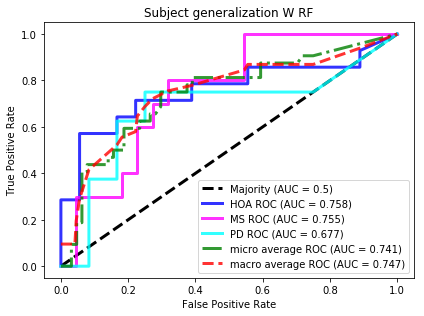

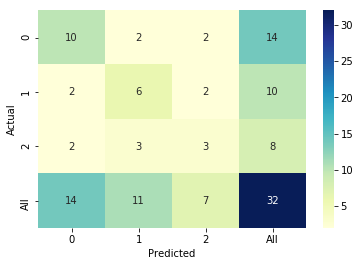

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.5312292156979576, 0.5150662228240319, 0.4946826567027635, 0.49103486565631316, 0.7123940994796237]
Stride-based model performance (standard deviation):  [0.10120874989028403, 0.07729874462128918, 0.06962288381084072, 0.07261265087977918, 0.08088463905664775]
Person-based model performance (mean):  [0.562857142857143, 0.5444444444444444, 0.5399999999999999, 0.5055555555555555, 0.7444444444444445]
Person-based model performance (standard deviation):  [0.09629885455058697, 0.11331154474650632, 0.18587132147845767, 0.1150415920492869, 0.14016084235047627]


<Figure size 432x288 with 0 Axes>

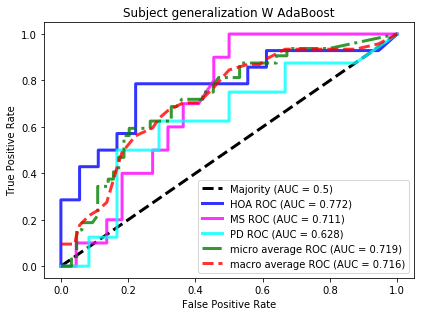

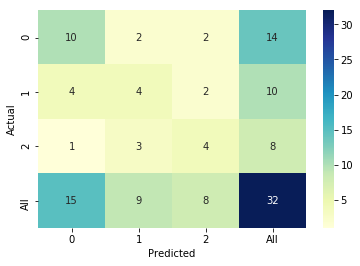

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}
Stride-based model performance (mean):  [0.5756185873350468, 0.6455733225859379, 0.4815944964705515, 0.46201466750929454, 0.7611939431249589]
Stride-based model performance (standard deviation):  [0.06499245895907965, 0.16451947756463686, 0.0471951968160351, 0.052250186323821314, 0.08605499169612758]
Person-based model performance (mean):  [0.5676190476190476, 0.5222222222222221, 0.5, 0.4766666666666667, 0.736111111111111]
Person-based model performance (standard deviation):  [0.077746025264604, 0.090267093384844, 0.11737877907772673, 0.08723460633951344, 0.0837950173833242]


<Figure size 432x288 with 0 Axes>

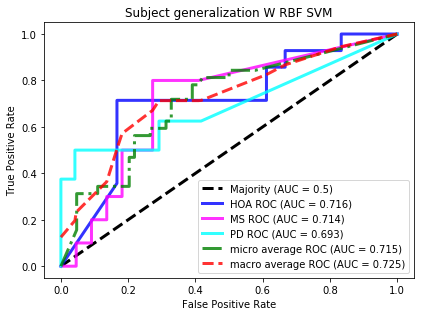

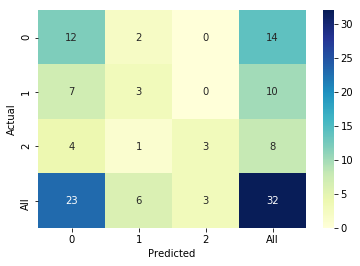

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.6071113057911739, 0.5924132128796005, 0.5653872705275331, 0.5423056788366616, 0.7653195068315937]
Stride-based model performance (standard deviation):  [0.1244341892965032, 0.11357770872271503, 0.08626250961003107, 0.10402199534697616, 0.10959733256157414]
Person-based model performance (mean):  [0.6409523809523809, 0.6444444444444445, 0.6444444444444444, 0.6025396825396825, 0.8472222222222221]
Person-based model performance (standard deviation):  [0.15302245918777094, 0.1911627837120584, 0.23465235646603194, 0.2111471505220835, 0.1675900347666484]


<Figure size 432x288 with 0 Axes>

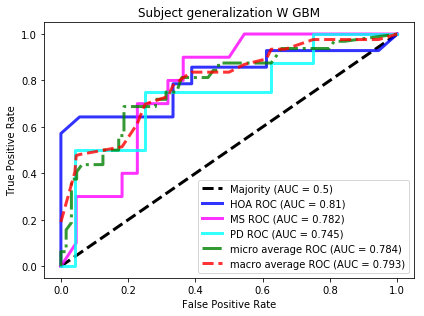

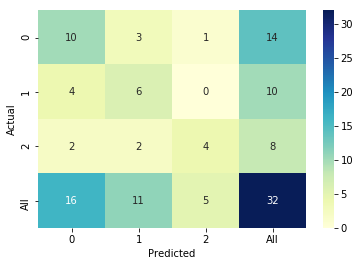

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.6}
Stride-based model performance (mean):  [0.589053975653368, 0.571543270126796, 0.5420420697632509, 0.5119230136942352, 0.7565545616018234]
Stride-based model performance (standard deviation):  [0.1103766623452067, 0.09313391310893497, 0.06733694544823057, 0.07451952536352827, 0.09050865970639793]
Person-based model performance (mean):  [0.5390476190476191, 0.5111111111111111, 0.44444444444444436, 0.4358730158730159, 0.8069444444444442]
Person-based model performance (standard deviation):  [0.09535231246311487, 0.09558139185602918, 0.09938079899999067, 0.06043097088727298, 0.1373807002097582]


<Figure size 432x288 with 0 Axes>

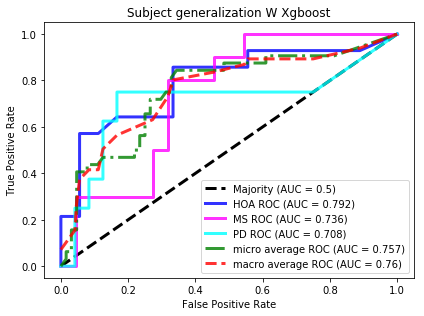

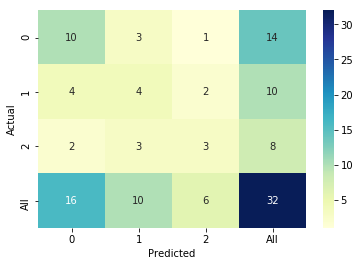

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 1}
Stride-based model performance (mean):  [0.6014415104594626, 0.5709726179303061, 0.5479209457496796, 0.5377592762235388, 0.6609407093122597]
Stride-based model performance (standard deviation):  [0.0954378061555806, 0.09935625648841995, 0.07530277986109876, 0.08128787193331043, 0.05647708489582404]
Person-based model performance (mean):  [0.62, 0.5888888888888888, 0.5455555555555556, 0.5382539682539682, 0.8166666666666667]
Person-based model performance (standard deviation):  [0.08359279336187313, 0.10886621079036347, 0.17993139982219702, 0.10014904488678834, 0.14120294474598705]


<Figure size 432x288 with 0 Axes>

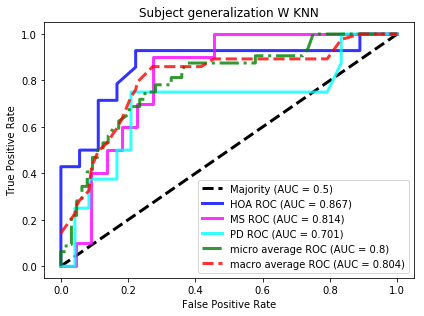

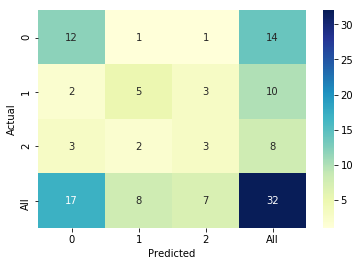

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 20}
Stride-based model performance (mean):  [0.5300318592236833, 0.5014352173893973, 0.4811543331491353, 0.4719273798190412, 0.6261066871033325]
Stride-based model performance (standard deviation):  [0.138891686311594, 0.15697474012599594, 0.11366577611624298, 0.12915939014057767, 0.09800286822635652]
Person-based model performance (mean):  [0.5438095238095239, 0.5222222222222223, 0.43888888888888883, 0.4606349206349207, 0.7027777777777777]
Person-based model performance (standard deviation):  [0.2872403688175777, 0.2548298875817715, 0.2851250537856964, 0.25564210306138296, 0.21256807188565544]


<Figure size 432x288 with 0 Axes>

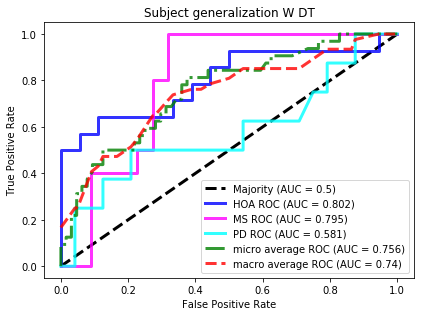

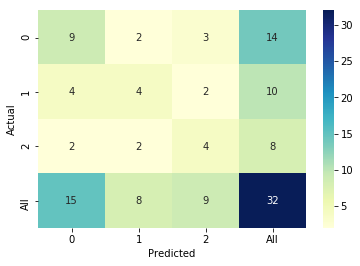

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.5957414495216629, 0.5946698461902928, 0.5625452612272918, 0.5440508026066442, 0.7373045823976163]
Stride-based model performance (standard deviation):  [0.14348680217619816, 0.14845108600703277, 0.12006122879724519, 0.1488096789163685, 0.1135176890276172]
Person-based model performance (mean):  [0.6647619047619048, 0.6555555555555556, 0.5777777777777777, 0.5892063492063493, 0.8305555555555557]
Person-based model performance (standard deviation):  [0.22011334948456718, 0.22607766610417562, 0.293131243517176, 0.26053881413514923, 0.1517388920416407]


<Figure size 432x288 with 0 Axes>

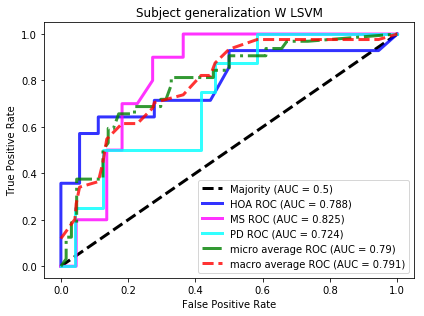

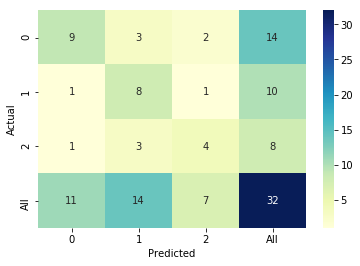

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.6073064497879757, 0.6014394517471382, 0.5871851192639117, 0.5667404990790348, 0.7486859897620752]
Stride-based model performance (standard deviation):  [0.1818032411418804, 0.18896420777995107, 0.1588848353107709, 0.18669122723864903, 0.11279697537750115]
Person-based model performance (mean):  [0.6361904761904762, 0.6222222222222222, 0.5655555555555556, 0.5593650793650793, 0.8305555555555557]
Person-based model performance (standard deviation):  [0.18044037840441968, 0.18053418676968805, 0.2655625289646931, 0.21202356814569354, 0.20363214231234728]


<Figure size 432x288 with 0 Axes>

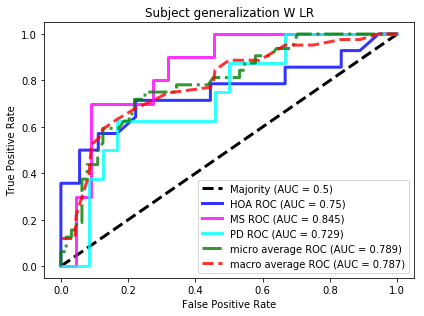

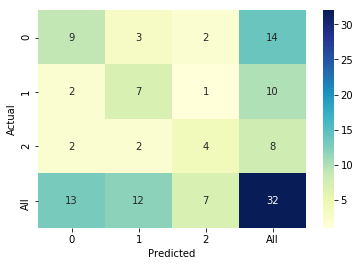

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 10, 150, 50, 20, 20, 100)}
Stride-based model performance (mean):  [0.6053007579073946, 0.6156116433047256, 0.563641369475518, 0.5470770829408713, 0.7737691945014661]
Stride-based model performance (standard deviation):  [0.10272601827291113, 0.07401442173988657, 0.055450695527766075, 0.07176957534167135, 0.09298654238227914]
Person-based model performance (mean):  [0.6361904761904762, 0.611111111111111, 0.65, 0.5822222222222223, 0.8555555555555555]
Person-based model performance (standard deviation):  [0.12740564958621448, 0.14487116456005888, 0.17881641043812313, 0.15549205052920803, 0.14635488747021652]


<Figure size 432x288 with 0 Axes>

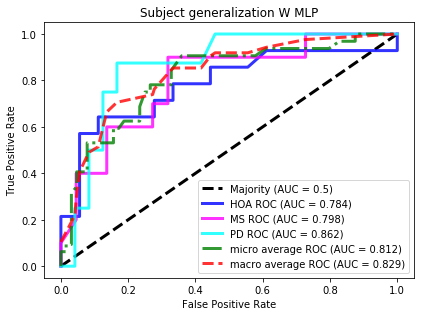

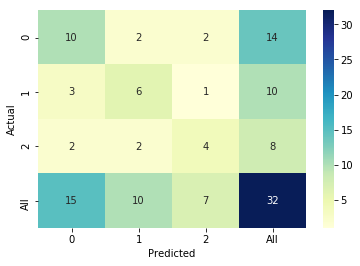

********************************


In [9]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics = run_ml_models(ml_models, X, Y, framework)

In [10]:
metrics

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.585098  0.531229    0.575619  0.607111   
stride_mean_precision       0.554834  0.515066    0.645573  0.592413   
stride_mean_recall          0.546269  0.494683    0.481594  0.565387   
stride_mean_F1              0.506065  0.491035    0.462015  0.542306   
stride_mean_AUC             0.769131  0.712394    0.761194  0.765320   
stride_std_accuracy         0.141973  0.101209    0.064992  0.124434   
stride_std_precision        0.123762  0.077299    0.164519  0.113578   
stride_std_recall           0.083541  0.069623    0.047195  0.086263   
stride_std_F1               0.105663  0.072613    0.052250  0.104022   
stride_std_AUC              0.090827  0.080885    0.086055  0.109597   
person_mean_accuracy        0.600952  0.562857    0.567619  0.640952   
person_mean_precision       0.577778  0.544444    0.522222  0.644444   
person_mean_recall          0.478889  0.540000    0.500000  0.644444   
person_mean_F1              0.494444  0.505556    0.476667  0.602540   
person_mean_AUC             0.779167  0.744444    0.736111  0.847222   
person_std_accuracy         0.182808  0.096299    0.077746  0.153022   
person_std_precision        0.129577  0.113312    0.090267  0.191163   
person_std_recall           0.225104  0.185871    0.117379  0.234652   
person_std_F1               0.152429  0.115042    0.087235  0.211147   
person_std_AUC              0.170805  0.140161    0.083795  0.167590   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.589054  0.601442       0.530032    0.595741   
stride_mean_precision  0.571543  0.570973       0.501435    0.594670   
stride_mean_recall     0.542042  0.547921       0.481154    0.562545   
stride_mean_F1         0.511923  0.537759       0.471927    0.544051   
stride_mean_AUC        0.756555  0.660941       0.626107    0.737305   
stride_std_accuracy    0.110377  0.095438       0.138892    0.143487   
stride_std_precision   0.093134  0.099356       0.156975    0.148451   
stride_std_recall      0.067337  0.075303       0.113666    0.120061   
stride_std_F1          0.074520  0.081288       0.129159    0.148810   
stride_std_AUC         0.090509  0.056477       0.098003    0.113518   
person_mean_accuracy   0.539048  0.620000       0.543810    0.664762   
person_mean_precision  0.511111  0.588889       0.522222    0.655556   
person_mean_recall     0.444444  0.545556       0.438889    0.577778   
person_mean_F1         0.435873  0.538254       0.460635    0.589206   
person_mean_AUC        0.806944  0.816667       0.702778    0.830556   
person_std_accuracy    0.095352  0.083593       0.287240    0.220113   
person_std_precision   0.095581  0.108866       0.254830    0.226078   
person_std_recall      0.099381  0.179931       0.285125    0.293131   
person_std_F1          0.060431  0.100149       0.255642    0.260539   
person_std_AUC         0.137381  0.141203       0.212568    0.151739   

                       logistic_regression       mlp  
stride_mean_accuracy              0.607306  0.605301  
stride_mean_precision             0.601439  0.615612  
stride_mean_recall                0.587185  0.563641  
stride_mean_F1                    0.566740  0.547077  
stride_mean_AUC                   0.748686  0.773769  
stride_std_accuracy               0.181803  0.102726  
stride_std_precision              0.188964  0.074014  
stride_std_recall                 0.158885  0.055451  
stride_std_F1                     0.186691  0.071770  
stride_std_AUC                    0.112797  0.092987  
person_mean_accuracy              0.636190  0.636190  
person_mean_precision             0.622222  0.611111  
person_mean_recall                0.565556  0.650000  
person_mean_F1                    0.559365  0.582222  
person_mean_AUC                   0.830556  0.855556  
person_std_accuracy               0.180440  0.127406  
person_std_precision              0.180534  0.144871  
person_

### Subject generalization framework 2: walking while talking (WT) to classify strides and subjects of HOA/MS/PD

In [11]:
#Trial WT for the second framework of subject generalization
trialWT = data[data['scenario']=='WT']
print ('Original number of subjects in trial WT for cross validation:', len(trialWT['PID'].unique()))
print ('Number of subjects in trial WT in each cohort:\n', trialWT.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialWT = shuffle(trialWT, random_state = 0)
#CV for people generalize so no train-test split
X_WT = trialWT.drop(cols_to_drop, axis = 1)
Y_WT = trialWT[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial WT for cross validation: ', len(trialWT))
print ('HOA, MS and PD strides in trial WT:\n', trialWT['cohort'].value_counts())
print ('Imbalance ratio in trial WT (controls:MS:PD)= 1:X:Y\n', trialWT['cohort'].value_counts()/trialWT['cohort'].value_counts()['HOA'])
#Defining the framework of interest
framework = 'WT'

Original number of subjects in trial WT for cross validation: 26
Number of subjects in trial WT in each cohort:
 MS     9
PD     9
HOA    8
Name: cohort, dtype: int64
Strides in trial WT for cross validation:  1176
HOA, MS and PD strides in trial WT:
 PD     493
HOA    351
MS     332
Name: cohort, dtype: int64
Imbalance ratio in trial WT (controls:MS:PD)= 1:X:Y
 PD     1.404558
HOA    1.000000
MS     0.945869
Name: cohort, dtype: float64


random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 0.1, 'randomforestclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.5306601912062647, 0.4573400174376149, 0.46890301955501634, 0.4416006324329613, 0.7189214272033014]
Stride-based model performance (standard deviation):  [0.12304964602258625, 0.19268866316818653, 0.13791920549431536, 0.15208548384716725, 0.1425009517702155]
Person-based model performance (mean):  [0.4666666666666666, 0.4666666666666666, 0.45555555555555555, 0.42222222222222217, 0.6333333333333333]
Person-based model performance (standard deviation):  [0.18708286933869703, 0.19436506316151, 0.23674750836291686, 0.19436506316151, 0.17804883849351247]


<Figure size 432x288 with 0 Axes>

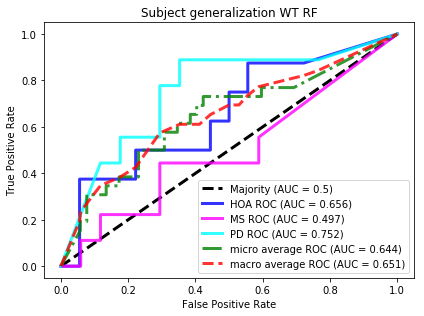

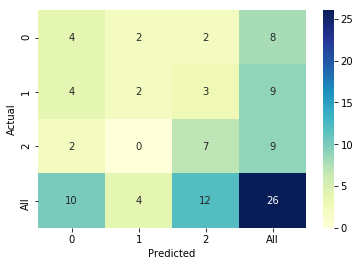

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.5389939553339254, 0.495522166375087, 0.49536010986537704, 0.4805986421415044, 0.6807384404168054]
Stride-based model performance (standard deviation):  [0.15742007108222422, 0.17348525224011346, 0.1521783588495575, 0.1585433175060468, 0.17808127361731946]
Person-based model performance (mean):  [0.41666666666666663, 0.39999999999999997, 0.3711111111111111, 0.3425396825396826, 0.675]
Person-based model performance (standard deviation):  [0.18257418583505536, 0.1699673171197595, 0.2681072201218786, 0.1922310694882427, 0.20649186155606447]


<Figure size 432x288 with 0 Axes>

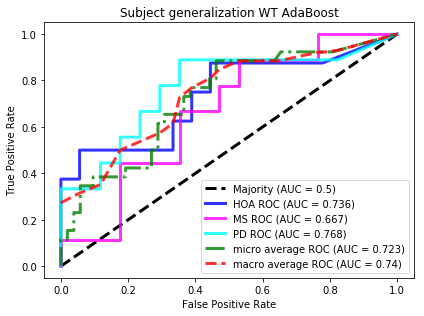

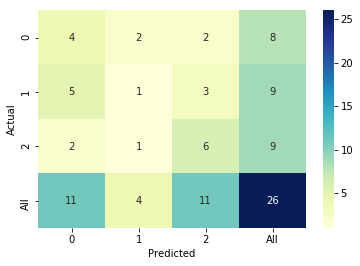

********************************
kernel_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.5531566395741723, 0.4850355210593064, 0.49499198581478954, 0.470701166351029, 0.7008547453921273]
Stride-based model performance (standard deviation):  [0.14108713262016942, 0.2273082838393687, 0.15611084243823578, 0.1826481093454033, 0.1451460432293997]
Person-based model performance (mean):  [0.4833333333333333, 0.4666666666666667, 0.45555555555555555, 0.42444444444444435, 0.6833333333333333]
Person-based model performance (standard deviation):  [0.1699673171197595, 0.1632993161855452, 0.27532248207475263, 0.20115714635792634, 0.20471864160897077]


<Figure size 432x288 with 0 Axes>

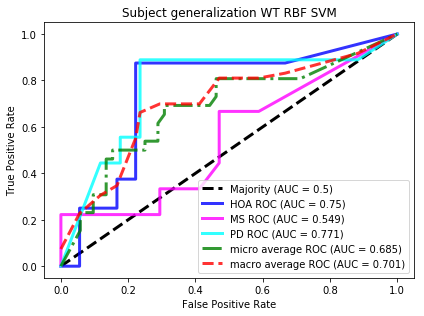

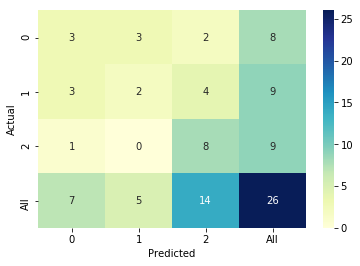

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.5551027120054082, 0.5199941478604158, 0.5080496967151552, 0.49299737681508515, 0.7097108266018587]
Stride-based model performance (standard deviation):  [0.12933740814471456, 0.14672897642680016, 0.13303440709511608, 0.13541117104700484, 0.1393472089098655]
Person-based model performance (mean):  [0.5, 0.4666666666666666, 0.42222222222222217, 0.4133333333333333, 0.7458333333333333]
Person-based model performance (standard deviation):  [0.21081851067789198, 0.22110831935702666, 0.257240820062005, 0.22502674738136585, 0.16051133570215184]


<Figure size 432x288 with 0 Axes>

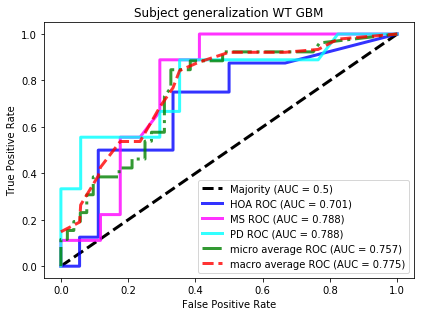

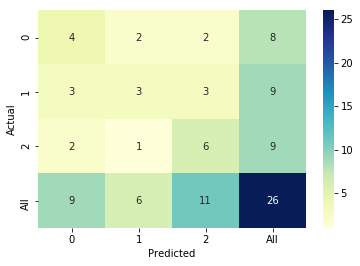

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__subsample': 1.0}
Stride-based model performance (mean):  [0.5614331744172982, 0.5249844635666411, 0.5223254573095084, 0.505716504891929, 0.7289962471346412]
Stride-based model performance (standard deviation):  [0.13587320662925978, 0.14942501331894759, 0.13872626086591885, 0.14336838905533444, 0.133897585173379]
Person-based model performance (mean):  [0.45, 0.4333333333333333, 0.4333333333333333, 0.4, 0.7583333333333333]
Person-based model performance (standard deviation):  [0.23333333333333334, 0.24944382578492943, 0.2543449587168799, 0.2375803957494062, 0.1736055554666638]


<Figure size 432x288 with 0 Axes>

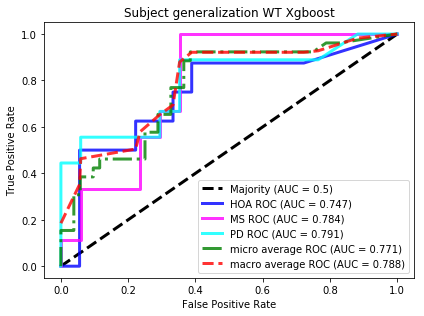

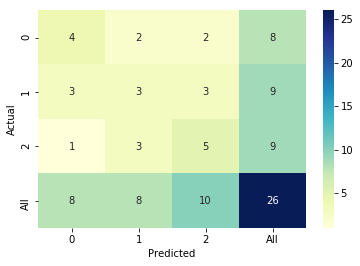

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 4}
Stride-based model performance (mean):  [0.5067038913164981, 0.5071555696192714, 0.4804620287293838, 0.4582389051495398, 0.6789999356088411]
Stride-based model performance (standard deviation):  [0.15747275104546937, 0.12866201484814382, 0.14814922416923032, 0.15974479303474745, 0.12464529916555442]
Person-based model performance (mean):  [0.4833333333333334, 0.5, 0.4222222222222222, 0.4222222222222222, 0.6666666666666667]
Person-based model performance (standard deviation):  [0.2, 0.18257418583505539, 0.25962936545662046, 0.21976418337913095, 0.17480147469502527]


<Figure size 432x288 with 0 Axes>

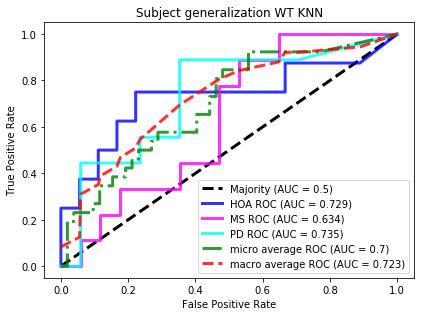

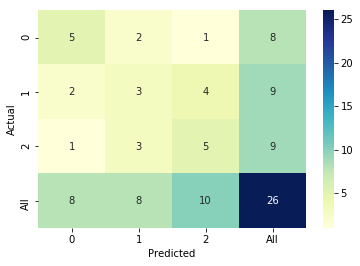

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 3}
Stride-based model performance (mean):  [0.5153989059420946, 0.49339353351618875, 0.48584063864474525, 0.47337823903869874, 0.615347932899444]
Stride-based model performance (standard deviation):  [0.1430217092027805, 0.12400195455763101, 0.13797736595766963, 0.1414499174205091, 0.10687656679588532]
Person-based model performance (mean):  [0.4833333333333333, 0.4666666666666666, 0.4155555555555555, 0.4203174603174603, 0.7291666666666666]
Person-based model performance (standard deviation):  [0.36666666666666664, 0.3559026084010437, 0.3511954891580162, 0.3502587317088926, 0.21164041832000488]


<Figure size 432x288 with 0 Axes>

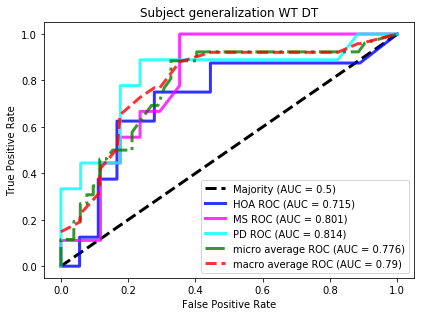

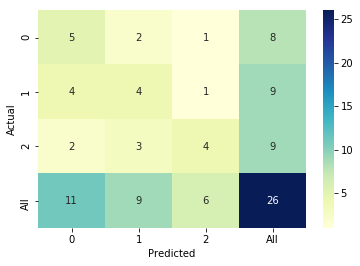

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.5100935389581989, 0.4877769204994066, 0.47706579560806917, 0.46185418527720684, 0.6703454430572736]
Stride-based model performance (standard deviation):  [0.15755436068444983, 0.1520309392594575, 0.15608470915606387, 0.15629792452498803, 0.13942350261299238]
Person-based model performance (mean):  [0.4833333333333333, 0.4666666666666666, 0.45555555555555555, 0.42444444444444446, 0.6833333333333333]
Person-based model performance (standard deviation):  [0.24944382578492946, 0.26666666666666666, 0.2543449587168799, 0.24589468788663207, 0.2084999333866134]


<Figure size 432x288 with 0 Axes>

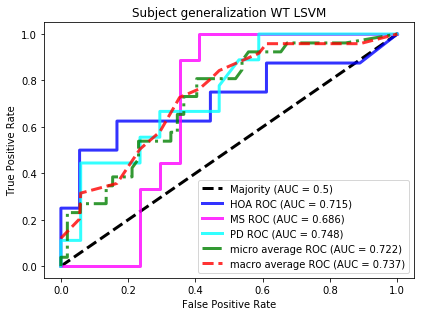

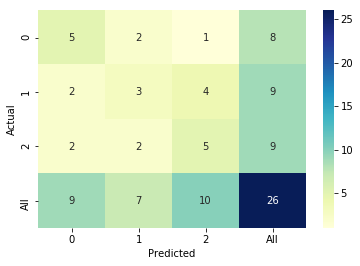

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.5183205321756251, 0.5048317012744121, 0.48007106183909604, 0.47195438375596055, 0.673339521765128]
Stride-based model performance (standard deviation):  [0.13469782706635644, 0.1354628964085644, 0.1398271647749139, 0.1403998822024788, 0.11142402845511637]
Person-based model performance (mean):  [0.36666666666666664, 0.36666666666666664, 0.3333333333333333, 0.31999999999999995, 0.7083333333333333]
Person-based model performance (standard deviation):  [0.18708286933869706, 0.19436506316151, 0.20184335693983277, 0.18127123119584987, 0.16666666666666669]


<Figure size 432x288 with 0 Axes>

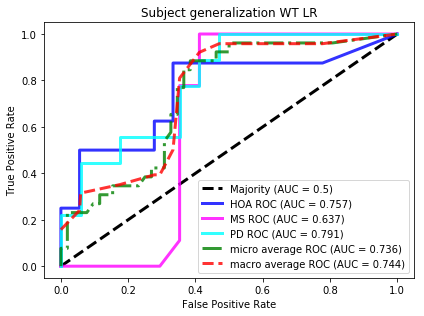

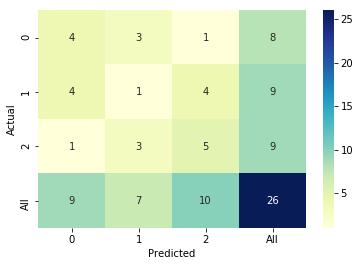

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (21, 84, 7, 7, 7, 84, 5)}
Stride-based model performance (mean):  [0.5601864495008828, 0.5505310777969853, 0.5273316051952588, 0.5165834203659221, 0.7125289876333282]
Stride-based model performance (standard deviation):  [0.11532111538975655, 0.11206092606922366, 0.13411797421641958, 0.1346597188679059, 0.13239551855649495]
Person-based model performance (mean):  [0.7, 0.6666666666666666, 0.6777777777777778, 0.6399999999999999, 0.75]
Person-based model performance (standard deviation):  [0.19436506316151, 0.23570226039551584, 0.25434495871687995, 0.25304076673459086, 0.21081851067789195]


<Figure size 432x288 with 0 Axes>

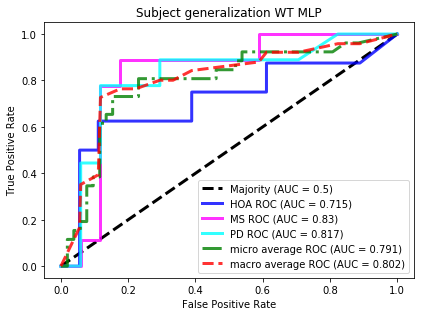

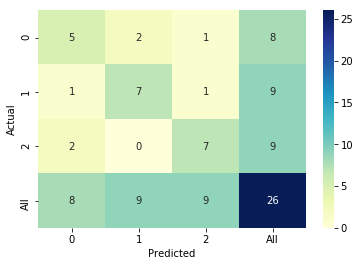

********************************


In [12]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_WT = run_ml_models(ml_models, X_WT, Y_WT, framework)

In [13]:
metrics_WT

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.530660  0.538994    0.553157  0.555103   
stride_mean_precision       0.457340  0.495522    0.485036  0.519994   
stride_mean_recall          0.468903  0.495360    0.494992  0.508050   
stride_mean_F1              0.441601  0.480599    0.470701  0.492997   
stride_mean_AUC             0.718921  0.680738    0.700855  0.709711   
stride_std_accuracy         0.123050  0.157420    0.141087  0.129337   
stride_std_precision        0.192689  0.173485    0.227308  0.146729   
stride_std_recall           0.137919  0.152178    0.156111  0.133034   
stride_std_F1               0.152085  0.158543    0.182648  0.135411   
stride_std_AUC              0.142501  0.178081    0.145146  0.139347   
person_mean_accuracy        0.466667  0.416667    0.483333  0.500000   
person_mean_precision       0.466667  0.400000    0.466667  0.466667   
person_mean_recall          0.455556  0.371111    0.455556  0.422222   
person_mean_F1              0.422222  0.342540    0.424444  0.413333   
person_mean_AUC             0.633333  0.675000    0.683333  0.745833   
person_std_accuracy         0.187083  0.182574    0.169967  0.210819   
person_std_precision        0.194365  0.169967    0.163299  0.221108   
person_std_recall           0.236748  0.268107    0.275322  0.257241   
person_std_F1               0.194365  0.192231    0.201157  0.225027   
person_std_AUC              0.178049  0.206492    0.204719  0.160511   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.561433  0.506704       0.515399    0.510094   
stride_mean_precision  0.524984  0.507156       0.493394    0.487777   
stride_mean_recall     0.522325  0.480462       0.485841    0.477066   
stride_mean_F1         0.505717  0.458239       0.473378    0.461854   
stride_mean_AUC        0.728996  0.679000       0.615348    0.670345   
stride_std_accuracy    0.135873  0.157473       0.143022    0.157554   
stride_std_precision   0.149425  0.128662       0.124002    0.152031   
stride_std_recall      0.138726  0.148149       0.137977    0.156085   
stride_std_F1          0.143368  0.159745       0.141450    0.156298   
stride_std_AUC         0.133898  0.124645       0.106877    0.139424   
person_mean_accuracy   0.450000  0.483333       0.483333    0.483333   
person_mean_precision  0.433333  0.500000       0.466667    0.466667   
person_mean_recall     0.433333  0.422222       0.415556    0.455556   
person_mean_F1         0.400000  0.422222       0.420317    0.424444   
person_mean_AUC        0.758333  0.666667       0.729167    0.683333   
person_std_accuracy    0.233333  0.200000       0.366667    0.249444   
person_std_precision   0.249444  0.182574       0.355903    0.266667   
person_std_recall      0.254345  0.259629       0.351195    0.254345   
person_std_F1          0.237580  0.219764       0.350259    0.245895   
person_std_AUC         0.173606  0.174801       0.211640    0.208500   

                       logistic_regression       mlp  
stride_mean_accuracy              0.518321  0.560186  
stride_mean_precision             0.504832  0.550531  
stride_mean_recall                0.480071  0.527332  
stride_mean_F1                    0.471954  0.516583  
stride_mean_AUC                   0.673340  0.712529  
stride_std_accuracy               0.134698  0.115321  
stride_std_precision              0.135463  0.112061  
stride_std_recall                 0.139827  0.134118  
stride_std_F1                     0.140400  0.134660  
stride_std_AUC                    0.111424  0.132396  
person_mean_accuracy              0.366667  0.700000  
person_mean_precision             0.366667  0.666667  
person_mean_recall                0.333333  0.677778  
person_mean_F1                    0.320000  0.640000  
person_mean_AUC                   0.708333  0.750000  
person_std_accuracy               0.187083  0.194365  
person_std_precision              0.194365  0.235702  
person_

### Subject generalization framework 3: virtual beam walking (VBW) to classify strides and subjects of HOA/MS/PD

In [14]:
#Trial VBW for the third framework of subject generalization
trialVBW = data[data['scenario']=='SLW']
print ('Original number of subjects in trial VBW for cross validation:', len(trialVBW['PID'].unique()))
print ('Number of subjects in trial VBW in each cohort:\n', trialVBW.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialVBW = shuffle(trialVBW, random_state = 0)
#CV for people generalize so no train-test split
X_VBW = trialVBW.drop(cols_to_drop, axis = 1)
Y_VBW = trialVBW[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial VBW for cross validation: ', len(trialVBW))
print ('HOA, MS and PD strides in trial VBW:\n', trialVBW['cohort'].value_counts())
print ('Imbalance ratio in trial VBW (controls:MS:PD)= 1:X:Y\n', trialVBW['cohort'].value_counts()/trialVBW['cohort'].value_counts()['HOA'])
#Defining the framework of interest
framework = 'VBW'

Original number of subjects in trial VBW for cross validation: 22
Number of subjects in trial VBW in each cohort:
 HOA    8
MS     8
PD     6
Name: cohort, dtype: int64
Strides in trial VBW for cross validation:  829
HOA, MS and PD strides in trial VBW:
 HOA    336
MS     283
PD     210
Name: cohort, dtype: int64
Imbalance ratio in trial VBW (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.842262
PD     0.625000
Name: cohort, dtype: float64


random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 40}
Stride-based model performance (mean):  [0.4160654862553207, 0.4152288899175113, 0.384854609166252, 0.37236690304521936, 0.5799105034294841]
Stride-based model performance (standard deviation):  [0.07605814058179522, 0.09281291261826642, 0.08236475422200332, 0.07722055778271371, 0.06971811954926234]
Person-based model performance (mean):  [0.4133333333333333, 0.4, 0.28888888888888886, 0.32666666666666666, 0.625]
Person-based model performance (standard deviation):  [0.21249836600678967, 0.2260776661041756, 0.17356110390903678, 0.1890326250501043, 0.1263812574008592]


<Figure size 432x288 with 0 Axes>

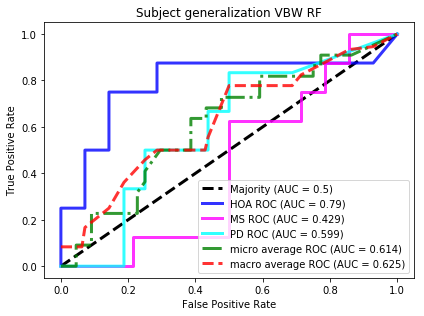

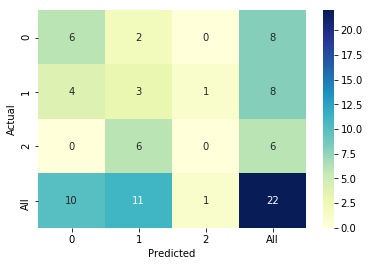

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.41752037001312015, 0.3551528114673704, 0.3801387620355389, 0.3545241176080899, 0.5410717687524988]
Stride-based model performance (standard deviation):  [0.06421365672504908, 0.06329708780808428, 0.08652371903080858, 0.0692116112090394, 0.04996307093280689]
Person-based model performance (mean):  [0.38666666666666666, 0.36666666666666664, 0.22666666666666666, 0.2736507936507936, 0.5541666666666666]
Person-based model performance (standard deviation):  [0.154344492037203, 0.1632993161855452, 0.1417004317060432, 0.1474930337722357, 0.05204164998665331]


<Figure size 432x288 with 0 Axes>

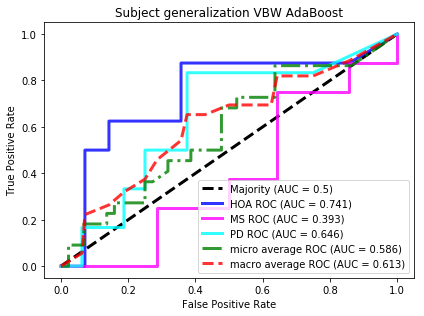

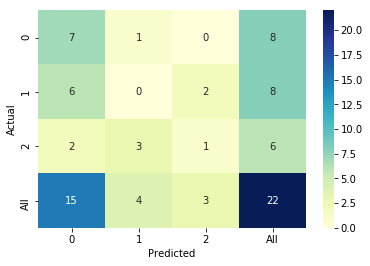

********************************
kernel_svm
best_params:  {'svc__gamma': 1}
Stride-based model performance (mean):  [0.39863189492674633, 0.13287729830891543, 0.3333333333333333, 0.18947538523243493, 0.4430471895443254]
Stride-based model performance (standard deviation):  [0.04672968131214522, 0.015576560437381747, 0.0, 0.01601607018712515, 0.07151209005298251]
Person-based model performance (mean):  [0.36, 0.3333333333333333, 0.11999999999999997, 0.17619047619047618, 0.5]
Person-based model performance (standard deviation):  [0.03265986323710906, 0.0, 0.01088662107903635, 0.0116642368703961, 0.0]


<Figure size 432x288 with 0 Axes>

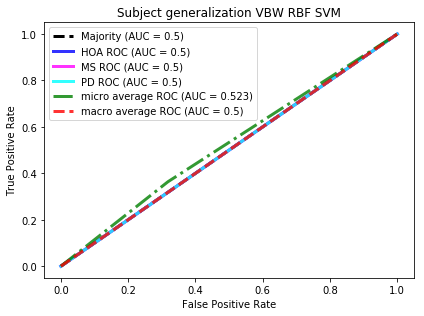

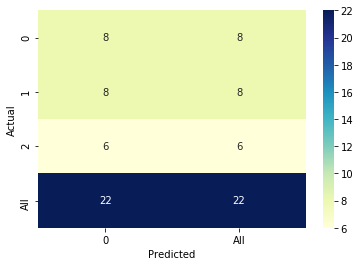

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 100}
Stride-based model performance (mean):  [0.42557562547412153, 0.40596535842120146, 0.3941433132445971, 0.3765656145456317, 0.5684486948204311]
Stride-based model performance (standard deviation):  [0.04400530138421885, 0.07203079635606911, 0.05813858587600986, 0.052708974442732634, 0.0708519224002517]
Person-based model performance (mean):  [0.4533333333333333, 0.4333333333333333, 0.3, 0.3488888888888889, 0.6166666666666667]
Person-based model performance (standard deviation):  [0.18571184369578825, 0.19999999999999998, 0.15153535218873174, 0.168303077588991, 0.08079466429027217]


<Figure size 432x288 with 0 Axes>

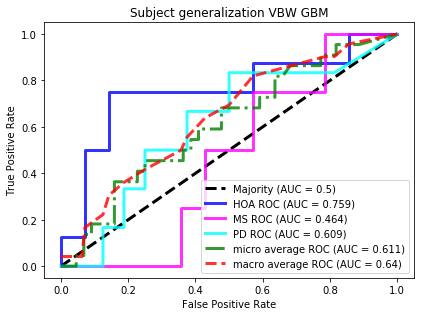

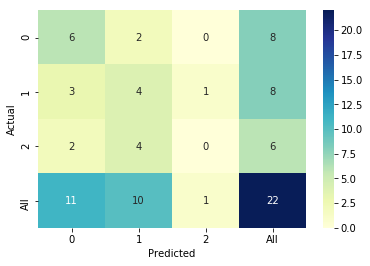

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.6}
Stride-based model performance (mean):  [0.41777980768117057, 0.3778964548048813, 0.38256081819915877, 0.3637765034689527, 0.5808706728101368]
Stride-based model performance (standard deviation):  [0.04104766232175671, 0.07222987667804064, 0.05663850884679006, 0.058693621128129675, 0.055447851044874756]
Person-based model performance (mean):  [0.41999999999999993, 0.4, 0.3, 0.33555555555555555, 0.5]
Person-based model performance (standard deviation):  [0.15719768163402126, 0.1699673171197595, 0.12957670877434002, 0.1418397635309595, 0.120761472884912]


<Figure size 432x288 with 0 Axes>

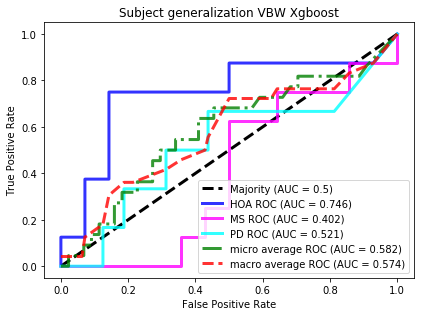

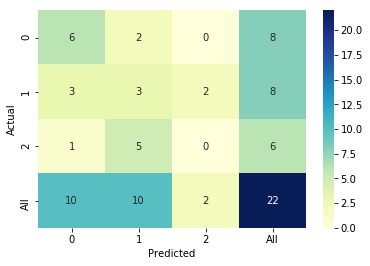

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 1}
Stride-based model performance (mean):  [0.44937559718750075, 0.4258287011353154, 0.4272923125517821, 0.40621825493833236, 0.5752873670177485]
Stride-based model performance (standard deviation):  [0.10460575351072145, 0.1077838649058329, 0.10796756950455118, 0.09275680389858981, 0.08388415252939042]
Person-based model performance (mean):  [0.5199999999999999, 0.5, 0.34444444444444444, 0.3999999999999999, 0.6]
Person-based model performance (standard deviation):  [0.1904380914278093, 0.21081851067789195, 0.1699673171197595, 0.18378731669453627, 0.16372402253657084]


<Figure size 432x288 with 0 Axes>

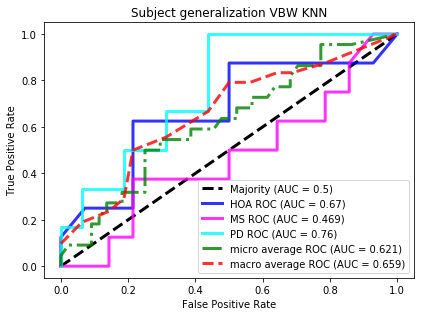

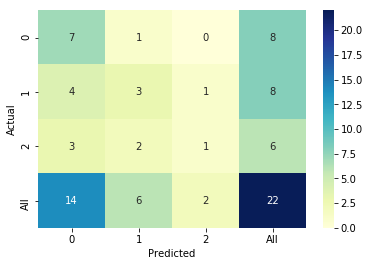

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 33}
Stride-based model performance (mean):  [0.44259333225346087, 0.4113902936832374, 0.4349824233321041, 0.40701453822968636, 0.5724384261844943]
Stride-based model performance (standard deviation):  [0.128344878019734, 0.13830547060547232, 0.14602479267390275, 0.1437302910245514, 0.09607319406281924]
Person-based model performance (mean):  [0.42666666666666664, 0.4333333333333333, 0.34444444444444444, 0.36, 0.6166666666666667]
Person-based model performance (standard deviation):  [0.17688665548562132, 0.19999999999999998, 0.21773242158072695, 0.1953281506075176, 0.20649186155606447]


<Figure size 432x288 with 0 Axes>

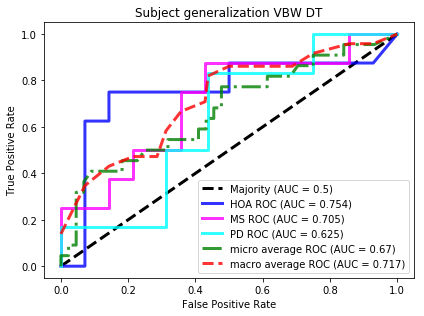

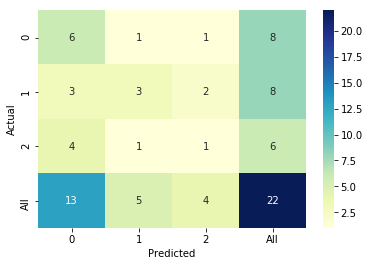

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.40896126899390844, 0.34109780911904575, 0.3772865179542328, 0.3487746742853093, 0.5183613965878608]
Stride-based model performance (standard deviation):  [0.07714489605669521, 0.10913296991773469, 0.06624651654265742, 0.09426263734291065, 0.1267407531864327]
Person-based model performance (mean):  [0.4666666666666667, 0.4333333333333333, 0.3488888888888889, 0.36476190476190473, 0.55]
Person-based model performance (standard deviation):  [0.1398411797560202, 0.13333333333333333, 0.16399337535551192, 0.14523731459587236, 0.1545603082582617]


<Figure size 432x288 with 0 Axes>

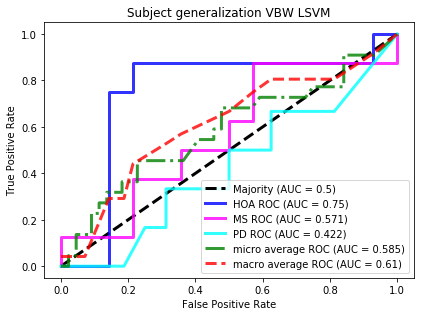

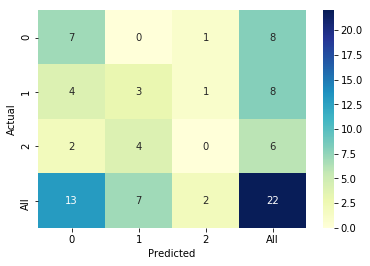

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.4320268935306456, 0.37306622192544575, 0.4009069703281475, 0.37240595805757964, 0.5204094488422686]
Stride-based model performance (standard deviation):  [0.09370257257211083, 0.1476687574018307, 0.09689022635660871, 0.1253957022824589, 0.12490706547000838]
Person-based model performance (mean):  [0.6066666666666667, 0.5666666666666667, 0.5000000000000001, 0.5111111111111112, 0.6416666666666667]
Person-based model performance (standard deviation):  [0.21949436844205775, 0.2260776661041756, 0.27888667551135854, 0.26152449546532935, 0.24381231397212985]


<Figure size 432x288 with 0 Axes>

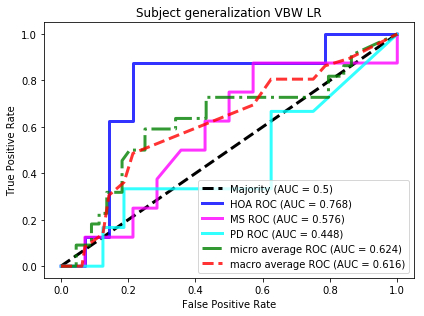

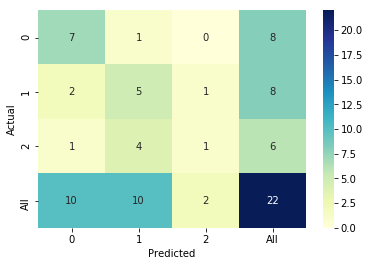

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (5, 5, 5, 5, 10, 100, 20, 100, 30, 5)}
Stride-based model performance (mean):  [0.4366885889744312, 0.4460074562877511, 0.4165554350278997, 0.409924261320793, 0.5785086950272653]
Stride-based model performance (standard deviation):  [0.040408534429169946, 0.04727995179965793, 0.02559183767210268, 0.02648887095825527, 0.03335178974294367]
Person-based model performance (mean):  [0.4666666666666667, 0.4333333333333333, 0.32222222222222224, 0.3555555555555555, 0.7499999999999999]
Person-based model performance (standard deviation):  [0.1398411797560202, 0.13333333333333333, 0.1625415426480866, 0.1515353521887317, 0.13176156917368248]


<Figure size 432x288 with 0 Axes>

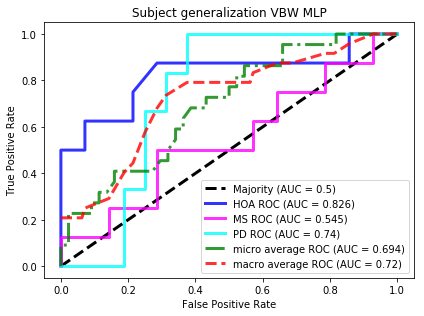

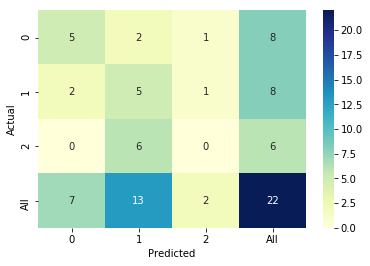

********************************


In [15]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VBW = run_ml_models(ml_models, X_VBW, Y_VBW, framework)

In [16]:
metrics_VBW

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.416065  0.417520    0.398632  0.425576   
stride_mean_precision       0.415229  0.355153    0.132877  0.405965   
stride_mean_recall          0.384855  0.380139    0.333333  0.394143   
stride_mean_F1              0.372367  0.354524    0.189475  0.376566   
stride_mean_AUC             0.579911  0.541072    0.443047  0.568449   
stride_std_accuracy         0.076058  0.064214    0.046730  0.044005   
stride_std_precision        0.092813  0.063297    0.015577  0.072031   
stride_std_recall           0.082365  0.086524    0.000000  0.058139   
stride_std_F1               0.077221  0.069212    0.016016  0.052709   
stride_std_AUC              0.069718  0.049963    0.071512  0.070852   
person_mean_accuracy        0.413333  0.386667    0.360000  0.453333   
person_mean_precision       0.400000  0.366667    0.333333  0.433333   
person_mean_recall          0.288889  0.226667    0.120000  0.300000   
person_mean_F1              0.326667  0.273651    0.176190  0.348889   
person_mean_AUC             0.625000  0.554167    0.500000  0.616667   
person_std_accuracy         0.212498  0.154344    0.032660  0.185712   
person_std_precision        0.226078  0.163299    0.000000  0.200000   
person_std_recall           0.173561  0.141700    0.010887  0.151535   
person_std_F1               0.189033  0.147493    0.011664  0.168303   
person_std_AUC              0.126381  0.052042    0.000000  0.080795   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.417780  0.449376       0.442593    0.408961   
stride_mean_precision  0.377896  0.425829       0.411390    0.341098   
stride_mean_recall     0.382561  0.427292       0.434982    0.377287   
stride_mean_F1         0.363777  0.406218       0.407015    0.348775   
stride_mean_AUC        0.580871  0.575287       0.572438    0.518361   
stride_std_accuracy    0.041048  0.104606       0.128345    0.077145   
stride_std_precision   0.072230  0.107784       0.138305    0.109133   
stride_std_recall      0.056639  0.107968       0.146025    0.066247   
stride_std_F1          0.058694  0.092757       0.143730    0.094263   
stride_std_AUC         0.055448  0.083884       0.096073    0.126741   
person_mean_accuracy   0.420000  0.520000       0.426667    0.466667   
person_mean_precision  0.400000  0.500000       0.433333    0.433333   
person_mean_recall     0.300000  0.344444       0.344444    0.348889   
person_mean_F1         0.335556  0.400000       0.360000    0.364762   
person_mean_AUC        0.500000  0.600000       0.616667    0.550000   
person_std_accuracy    0.157198  0.190438       0.176887    0.139841   
person_std_precision   0.169967  0.210819       0.200000    0.133333   
person_std_recall      0.129577  0.169967       0.217732    0.163993   
person_std_F1          0.141840  0.183787       0.195328    0.145237   
person_std_AUC         0.120761  0.163724       0.206492    0.154560   

                       logistic_regression       mlp  
stride_mean_accuracy              0.432027  0.436689  
stride_mean_precision             0.373066  0.446007  
stride_mean_recall                0.400907  0.416555  
stride_mean_F1                    0.372406  0.409924  
stride_mean_AUC                   0.520409  0.578509  
stride_std_accuracy               0.093703  0.040409  
stride_std_precision              0.147669  0.047280  
stride_std_recall                 0.096890  0.025592  
stride_std_F1                     0.125396  0.026489  
stride_std_AUC                    0.124907  0.033352  
person_mean_accuracy              0.606667  0.466667  
person_mean_precision             0.566667  0.433333  
person_mean_recall                0.500000  0.322222  
person_mean_F1                    0.511111  0.355556  
person_mean_AUC                   0.641667  0.750000  
person_std_accuracy               0.219494  0.139841  
person_std_precision              0.226078  0.133333  
person_

### Subject generalization framework 4: virtual beam walking while talking (VBWT) to classify strides and subjects of HOA/MS/PD

In [17]:
#Trial VBWT for the fourth framework of subject generalization
trialVBWT = data[data['scenario']=='SLWT']
print ('Original number of subjects in trial VBWT for cross validation:', len(trialVBWT['PID'].unique()))
print ('Number of subjects in trial VBWT in each cohort:\n', trialVBWT.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialVBWT = shuffle(trialVBWT, random_state = 0)
#CV for people generalize so no train-test split
X_VBWT = trialVBWT.drop(cols_to_drop, axis = 1)
Y_VBWT = trialVBWT[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial VBWT for cross validation: ', len(trialVBWT))
print ('HOA, MS and PD strides in trial VBWT:\n', trialVBWT['cohort'].value_counts())
print ('Imbalance ratio in trial VBWT (controls:MS:PD)= 1:X:Y\n', trialVBWT['cohort'].value_counts()/trialVBWT['cohort'].value_counts()['HOA'])
#Defining the framework of interest
framework = 'VBWT'

Original number of subjects in trial VBWT for cross validation: 21
Number of subjects in trial VBWT in each cohort:
 HOA    8
MS     7
PD     6
Name: cohort, dtype: int64
Strides in trial VBWT for cross validation:  837
HOA, MS and PD strides in trial VBWT:
 HOA    341
MS     254
PD     242
Name: cohort, dtype: int64
Imbalance ratio in trial VBWT (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.744868
PD     0.709677
Name: cohort, dtype: float64


random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 0.1, 'randomforestclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.4361437162996463, 0.4660132877270204, 0.4463508758781223, 0.4082640665659024, 0.631461201088494]
Stride-based model performance (standard deviation):  [0.12317608669457142, 0.09083219322933694, 0.12666879378764112, 0.10732218974415848, 0.1537607992179886]
Person-based model performance (mean):  [0.4333333333333333, 0.4333333333333333, 0.34444444444444444, 0.36444444444444446, 0.6583333333333333]
Person-based model performance (standard deviation):  [0.23475755815545346, 0.24944382578492943, 0.18392161508052055, 0.19605995555655803, 0.15]


<Figure size 432x288 with 0 Axes>

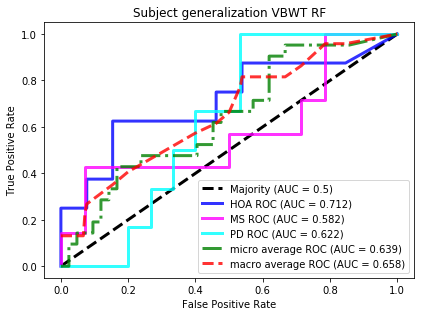

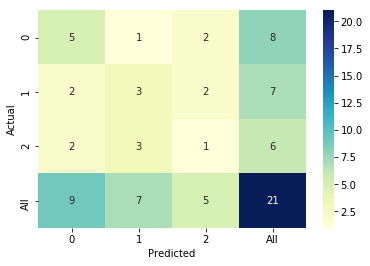

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.4566896480771782, 0.45628862019942174, 0.4603786662034571, 0.4228600433477642, 0.5901025745104153]
Stride-based model performance (standard deviation):  [0.12734839691109823, 0.11144433063980366, 0.13350611221626432, 0.11358606542134642, 0.1340526265315854]
Person-based model performance (mean):  [0.4833333333333333, 0.5, 0.36666666666666664, 0.38888888888888884, 0.6666666666666667]
Person-based model performance (standard deviation):  [0.14757295747452437, 0.14907119849998596, 0.13877773329774215, 0.1360827634879543, 0.2173067468400883]


<Figure size 432x288 with 0 Axes>

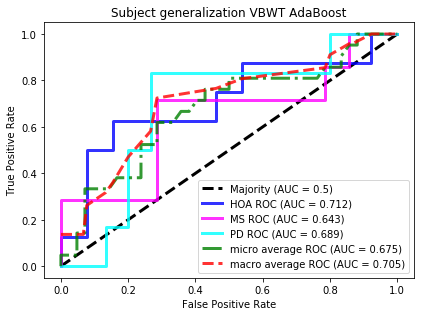

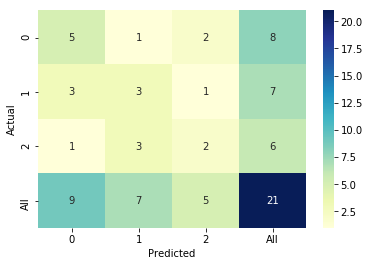

********************************
kernel_svm
best_params:  {'svc__gamma': 1}
Stride-based model performance (mean):  [0.40266004782880194, 0.13422001594293398, 0.3333333333333333, 0.19005057313026535, 0.4818399526226652]
Stride-based model performance (standard deviation):  [0.07361759539518099, 0.02453919846506033, 0.0, 0.025348546451362492, 0.0814511539003752]
Person-based model performance (mean):  [0.37666666666666665, 0.3333333333333333, 0.12555555555555556, 0.18063492063492062, 0.5]
Person-based model performance (standard deviation):  [0.08273115763993905, 0.0, 0.027577052546646347, 0.029515274410589105, 0.0]


<Figure size 432x288 with 0 Axes>

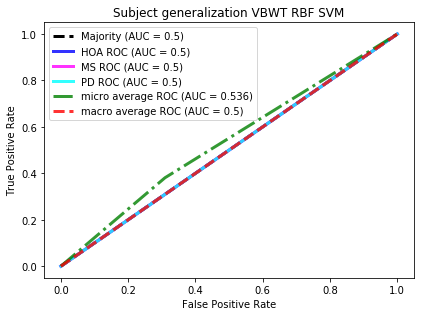

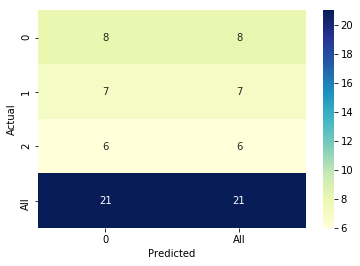

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 100}
Stride-based model performance (mean):  [0.43616006865162954, 0.43105972737390097, 0.4352235020883617, 0.39304981833759156, 0.6198554634080132]
Stride-based model performance (standard deviation):  [0.08440677027937345, 0.0738959702639497, 0.09125351124330079, 0.07409404203496572, 0.09516822673891137]
Person-based model performance (mean):  [0.3666666666666667, 0.36666666666666664, 0.25555555555555554, 0.27555555555555555, 0.575]
Person-based model performance (standard deviation):  [0.20439612955674524, 0.22110831935702666, 0.1706921277304135, 0.17290545479046143, 0.2242270674512285]


<Figure size 432x288 with 0 Axes>

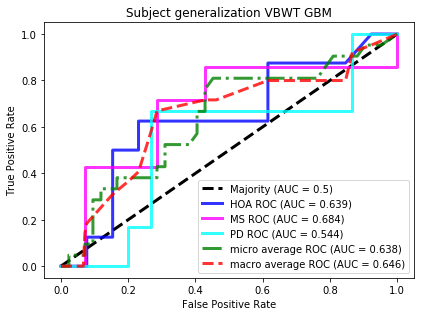

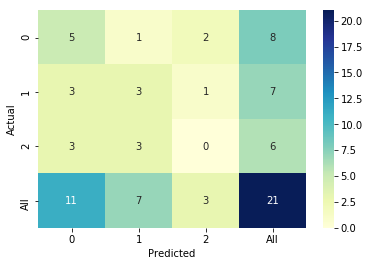

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1.5, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 1.0}
Stride-based model performance (mean):  [0.4317093814992042, 0.4226403850165542, 0.43237279883087154, 0.3924063680944323, 0.6376632000618516]
Stride-based model performance (standard deviation):  [0.09293406512929518, 0.10647973028832979, 0.09583761581262387, 0.08256928186409915, 0.13961103015993584]
Person-based model performance (mean):  [0.4166666666666667, 0.4, 0.26666666666666666, 0.3088888888888889, 0.6083333333333334]
Person-based model performance (standard deviation):  [0.25516878945339516, 0.2494438257849294, 0.18392161508052052, 0.20468584781634583, 0.21015867021530818]


<Figure size 432x288 with 0 Axes>

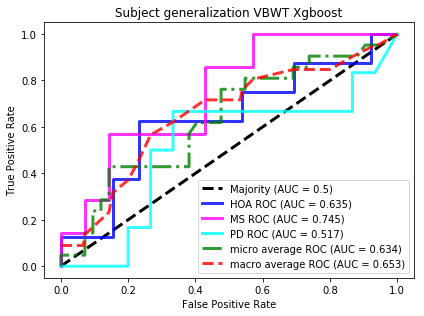

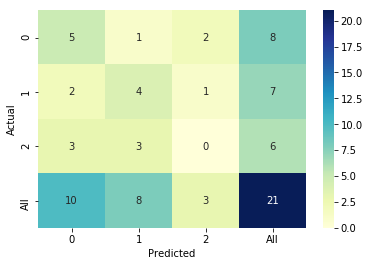

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 2}
Stride-based model performance (mean):  [0.39740503224663726, 0.36166684301490354, 0.37880809880871574, 0.3354228715262121, 0.5585598590805769]
Stride-based model performance (standard deviation):  [0.06163421624066779, 0.06804385554220241, 0.07974813953128211, 0.06223621696592761, 0.0962293638257536]
Person-based model performance (mean):  [0.5066666666666666, 0.4666666666666666, 0.3555555555555555, 0.38888888888888884, 0.575]
Person-based model performance (standard deviation):  [0.18577166390790364, 0.19436506316151, 0.1777777777777778, 0.18257418583505536, 0.22730302828309762]


<Figure size 432x288 with 0 Axes>

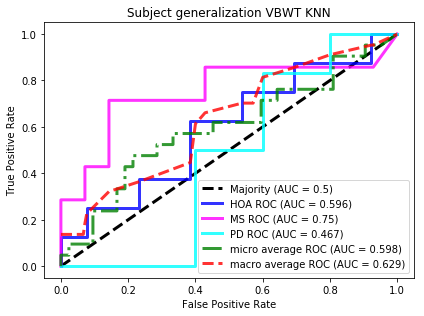

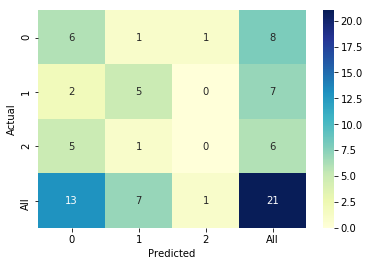

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 43}
Stride-based model performance (mean):  [0.49404217361646063, 0.4719170608006215, 0.49339848126437474, 0.45709568010006774, 0.6547885545316885]
Stride-based model performance (standard deviation):  [0.04459598184433341, 0.0575545840794397, 0.049688876244118815, 0.048831712423983965, 0.10593089246097215]
Person-based model performance (mean):  [0.5566666666666666, 0.5333333333333333, 0.4111111111111111, 0.4288888888888889, 0.7583333333333334]
Person-based model performance (standard deviation):  [0.13727506854649335, 0.1247219128924647, 0.134256066373273, 0.12444444444444445, 0.0927960727138337]


<Figure size 432x288 with 0 Axes>

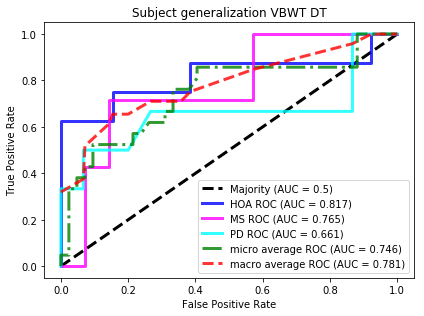

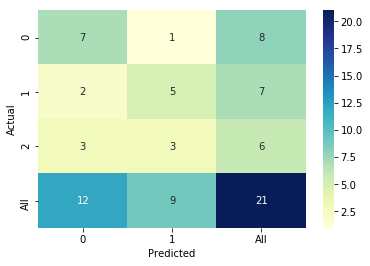

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.3938091369857975, 0.3868607491426647, 0.3728155127583518, 0.3304024019509492, 0.5856463763366293]
Stride-based model performance (standard deviation):  [0.08053178234215823, 0.09525610048349314, 0.07709515613124356, 0.0830673550024055, 0.1295871152182858]
Person-based model performance (mean):  [0.4066666666666666, 0.4, 0.3222222222222222, 0.31999999999999995, 0.6333333333333334]
Person-based model performance (standard deviation):  [0.22548712700383686, 0.2260776661041756, 0.22333056935824197, 0.20720360357226736, 0.19436506316151003]


<Figure size 432x288 with 0 Axes>

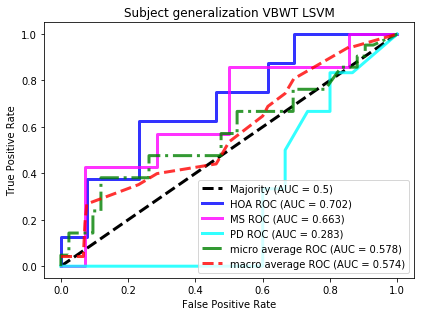

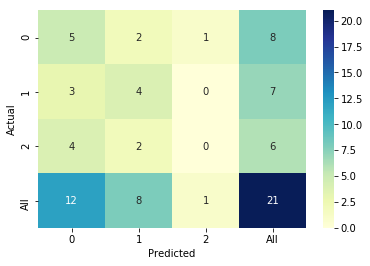

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.38904557473745804, 0.4028965644346882, 0.3773766643334947, 0.34032918355455877, 0.5660352260617929]
Stride-based model performance (standard deviation):  [0.10238509676660086, 0.11183840791729467, 0.08567859793329656, 0.08689405723533236, 0.14163964443285657]
Person-based model performance (mean):  [0.4066666666666666, 0.4, 0.29999999999999993, 0.30666666666666664, 0.6166666666666667]
Person-based model performance (standard deviation):  [0.22548712700383686, 0.2260776661041756, 0.20964402515681338, 0.19329501535984564, 0.1452966314513558]


<Figure size 432x288 with 0 Axes>

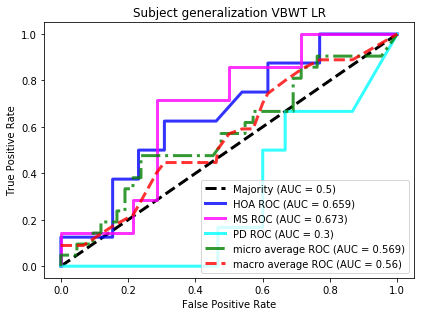

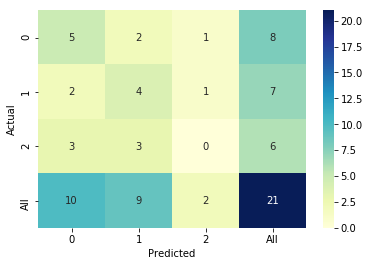

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (5, 5, 5, 5, 5, 20, 20, 100, 10, 10)}
Stride-based model performance (mean):  [0.4113794370078766, 0.404028530522434, 0.40141275989729774, 0.3657470144835719, 0.57406105533704]
Stride-based model performance (standard deviation):  [0.08815615337213219, 0.06398242435726888, 0.08947823562119306, 0.07812021692286934, 0.0814109491570583]
Person-based model performance (mean):  [0.45666666666666667, 0.4333333333333333, 0.36666666666666664, 0.3511111111111111, 0.625]
Person-based model performance (standard deviation):  [0.1420485050177501, 0.16996731711975946, 0.14740554623801774, 0.13418248123956025, 0.18633899812498247]


<Figure size 432x288 with 0 Axes>

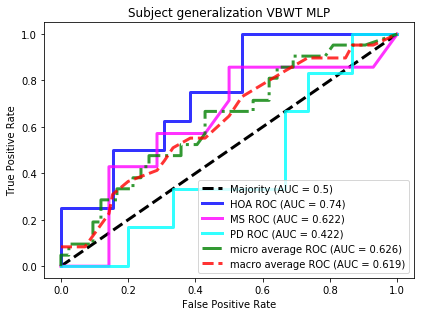

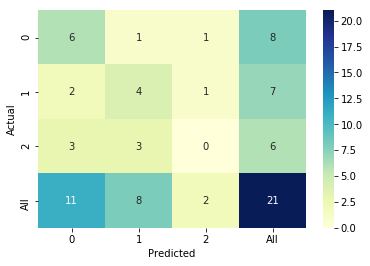

********************************


In [18]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VBWT = run_ml_models(ml_models, X_VBWT, Y_VBWT, framework)

In [19]:
metrics_VBWT

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.436144  0.456690    0.402660  0.436160   
stride_mean_precision       0.466013  0.456289    0.134220  0.431060   
stride_mean_recall          0.446351  0.460379    0.333333  0.435224   
stride_mean_F1              0.408264  0.422860    0.190051  0.393050   
stride_mean_AUC             0.631461  0.590103    0.481840  0.619855   
stride_std_accuracy         0.123176  0.127348    0.073618  0.084407   
stride_std_precision        0.090832  0.111444    0.024539  0.073896   
stride_std_recall           0.126669  0.133506    0.000000  0.091254   
stride_std_F1               0.107322  0.113586    0.025349  0.074094   
stride_std_AUC              0.153761  0.134053    0.081451  0.095168   
person_mean_accuracy        0.433333  0.483333    0.376667  0.366667   
person_mean_precision       0.433333  0.500000    0.333333  0.366667   
person_mean_recall          0.344444  0.366667    0.125556  0.255556   
person_mean_F1              0.364444  0.388889    0.180635  0.275556   
person_mean_AUC             0.658333  0.666667    0.500000  0.575000   
person_std_accuracy         0.234758  0.147573    0.082731  0.204396   
person_std_precision        0.249444  0.149071    0.000000  0.221108   
person_std_recall           0.183922  0.138778    0.027577  0.170692   
person_std_F1               0.196060  0.136083    0.029515  0.172905   
person_std_AUC              0.150000  0.217307    0.000000  0.224227   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.431709  0.397405       0.494042    0.393809   
stride_mean_precision  0.422640  0.361667       0.471917    0.386861   
stride_mean_recall     0.432373  0.378808       0.493398    0.372816   
stride_mean_F1         0.392406  0.335423       0.457096    0.330402   
stride_mean_AUC        0.637663  0.558560       0.654789    0.585646   
stride_std_accuracy    0.092934  0.061634       0.044596    0.080532   
stride_std_precision   0.106480  0.068044       0.057555    0.095256   
stride_std_recall      0.095838  0.079748       0.049689    0.077095   
stride_std_F1          0.082569  0.062236       0.048832    0.083067   
stride_std_AUC         0.139611  0.096229       0.105931    0.129587   
person_mean_accuracy   0.416667  0.506667       0.556667    0.406667   
person_mean_precision  0.400000  0.466667       0.533333    0.400000   
person_mean_recall     0.266667  0.355556       0.411111    0.322222   
person_mean_F1         0.308889  0.388889       0.428889    0.320000   
person_mean_AUC        0.608333  0.575000       0.758333    0.633333   
person_std_accuracy    0.255169  0.185772       0.137275    0.225487   
person_std_precision   0.249444  0.194365       0.124722    0.226078   
person_std_recall      0.183922  0.177778       0.134256    0.223331   
person_std_F1          0.204686  0.182574       0.124444    0.207204   
person_std_AUC         0.210159  0.227303       0.092796    0.194365   

                       logistic_regression       mlp  
stride_mean_accuracy              0.389046  0.411379  
stride_mean_precision             0.402897  0.404029  
stride_mean_recall                0.377377  0.401413  
stride_mean_F1                    0.340329  0.365747  
stride_mean_AUC                   0.566035  0.574061  
stride_std_accuracy               0.102385  0.088156  
stride_std_precision              0.111838  0.063982  
stride_std_recall                 0.085679  0.089478  
stride_std_F1                     0.086894  0.078120  
stride_std_AUC                    0.141640  0.081411  
person_mean_accuracy              0.406667  0.456667  
person_mean_precision             0.400000  0.433333  
person_mean_recall                0.300000  0.366667  
person_mean_F1                    0.306667  0.351111  
person_mean_AUC                   0.616667  0.625000  
person_std_accuracy               0.225487  0.142049  
person_std_precision              0.226078  0.169967  
person_

In [ ]:
#To do!
#ROC- Done 
#Confusion matrix files - Done
#CF itself - Done
#Saving all results to results folder - Done
#Comments in utility functions - Done
#micro macro weighted save all results 
#How can we compare different frameworks


### Compare traditional algorithms among the 4 sub-frameworks of subject generalization

In [61]:
#To compare across the 4 sub-frameworks of subject generalization, we reduce to common subjects across all 4 sub-frameworks 
#and then compare for the best accuracy/model in each sub-framework 

#Retaining the common PIDs across the 4 tasks 
common_pids = keep_common_PIDs(data, ['W', 'WT', 'SLW', 'SLWT'])

#Retaining the data with only common PIDs
reduced_data = data[data.PID.isin(common_pids)]
print ('Number of subjects in each cohort in reduced data with common PIDs:\n', \
       reduced_data.groupby('PID').first()['cohort'].value_counts())
design()
#Checking the retained strides in each task after reducing to commpn PIDs only
for scen in ['W', 'WT', 'SLW', 'SLWT']:
    reduced_data_scen = reduced_data[reduced_data.scenario==scen].reset_index().drop('index', axis = 1)
    print ('No. of strides retained in scenario', scen, 'are: ', reduced_data_scen.shape)
    print ('No. of strides retained for each cohort in scenario', scen, 'are:\n', reduced_data_scen['cohort'].value_counts())
    print ('Imbalance ratio in scenario', scen, '(controls:MS:PD)= 1:X:Y\n', \
           reduced_data_scen['cohort'].value_counts()/reduced_data_scen['cohort'].value_counts()['HOA'])
    design()

Original number of subjects in task W are: 32
Original number of subjects in task WT are: 26
Original number of subjects in task SLW are: 22
Original number of subjects in task SLWT are: 21
Common number of subjects across all frameworks:  19
Common subjects across all frameworks:  [406, 407, 408, 409, 410, 310, 311, 314, 318, 320, 321, 212, 213, 214, 215, 216, 217, 218, 219]
Number of subjects in each cohort in reduced data with common PIDs:
 HOA    8
MS     6
PD     5
Name: cohort, dtype: int64
******************************************
No. of strides retained in scenario W are:  (769, 99)
No. of strides retained for each cohort in scenario W are:
 HOA    334
MS     223
PD     212
Name: cohort, dtype: int64
Imbalance ratio in scenario W (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.667665
PD     0.634731
Name: cohort, dtype: float64
******************************************
No. of strides retained in scenario WT are:  (781, 99)
No. of strides retained for each cohort in scenario

#### Trial W

In [66]:
#Running the traditional models again for all sub-frameworks of suject generalization to give a ranking of best to worst 
#tasks for subject generalization 

#Trial W
reduced_data_W = reduced_data[reduced_data.scenario=='W'].reset_index().drop('index', axis = 1)
cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']

#Shuffling the cross validation stride data
reduced_data_W = shuffle(reduced_data_W, random_state = 0)
#CV for people generalize so no train-test split
X_reduced_data_W = reduced_data_W.drop(cols_to_drop, axis = 1)
Y_reduced_data_W = reduced_data_W[['PID', 'label']]

#Defining the framework of interest
framework = 'reducedW_for_comparision'

random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.4858910216671277, 0.526064889887725, 0.44052079398931354, 0.39604516312901555, 0.6327205622843758]
Stride-based model performance (standard deviation):  [0.09567486275245128, 0.10731051722584245, 0.05397367349764506, 0.05052346558017838, 0.06850631011771827]
Person-based model performance (mean):  [0.49333333333333335, 0.4333333333333333, 0.2777777777777778, 0.3088888888888889, 0.7083333333333333]
Person-based model performance (standard deviation):  [0.170489491367259, 0.13333333333333333, 0.18592445034090566, 0.16679994670929071, 0.2386303510546059]


<Figure size 432x288 with 0 Axes>

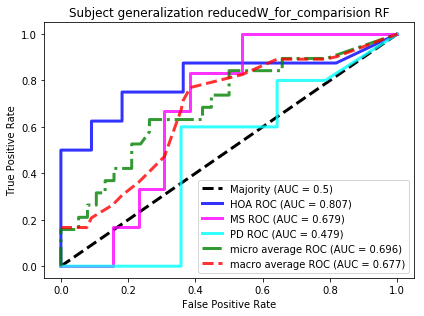

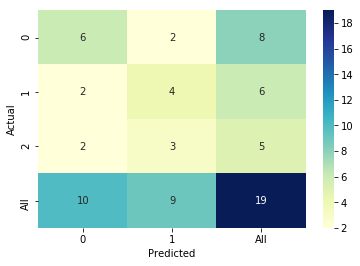

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.50263100873604, 0.47236297118090065, 0.4674094174874096, 0.4230746411672596, 0.5726549770211565]
Stride-based model performance (standard deviation):  [0.016658585575837378, 0.07661245595212493, 0.05266614473396068, 0.05061133301932359, 0.10620128019322689]
Person-based model performance (mean):  [0.49333333333333335, 0.4333333333333333, 0.3, 0.3311111111111111, 0.725]
Person-based model performance (standard deviation):  [0.170489491367259, 0.13333333333333333, 0.187905939169864, 0.16486432880881252, 0.19649710204252663]


<Figure size 432x288 with 0 Axes>

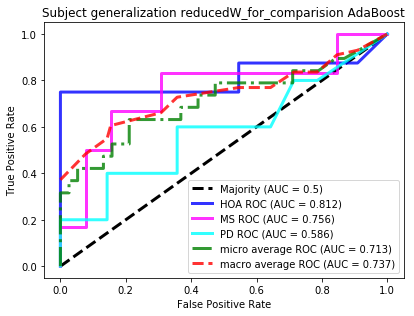

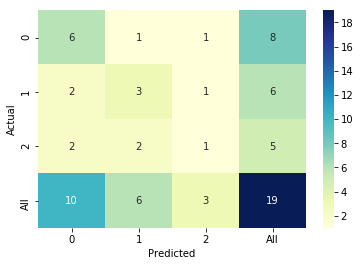

********************************
kernel_svm
best_params:  {'svc__gamma': 0.001}
Stride-based model performance (mean):  [0.5482978197789954, 0.5592150527163787, 0.5084480606786335, 0.4588410367974939, 0.742837121164993]
Stride-based model performance (standard deviation):  [0.04175279123490306, 0.10676492309364953, 0.0865825667377413, 0.10744467256922735, 0.03819181737103685]
Person-based model performance (mean):  [0.61, 0.5666666666666667, 0.4333333333333333, 0.4644444444444444, 0.7583333333333333]
Person-based model performance (standard deviation):  [0.1717879830230017, 0.2, 0.26620330112690976, 0.23332275108278552, 0.1674979270186815]


<Figure size 432x288 with 0 Axes>

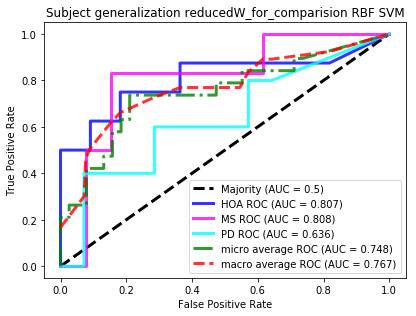

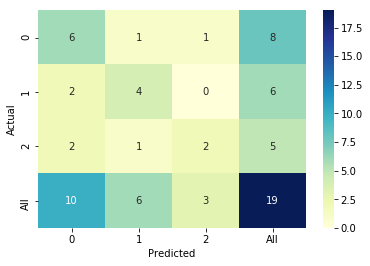

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 100}
Stride-based model performance (mean):  [0.5027594602588208, 0.5094640190580041, 0.46527249897641276, 0.43463962306835774, 0.6764619322758262]
Stride-based model performance (standard deviation):  [0.04737263026926424, 0.03420237332720115, 0.05525523396029773, 0.05934937112829933, 0.05912043277724698]
Person-based model performance (mean):  [0.5033333333333333, 0.4666666666666667, 0.34444444444444444, 0.36666666666666664, 0.7583333333333333]
Person-based model performance (standard deviation):  [0.16, 0.19436506316151003, 0.28414915227876497, 0.23985592383247667, 0.17159383568311665]


<Figure size 432x288 with 0 Axes>

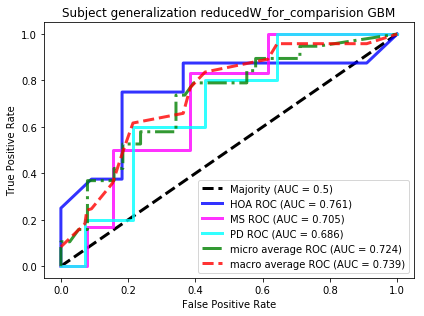

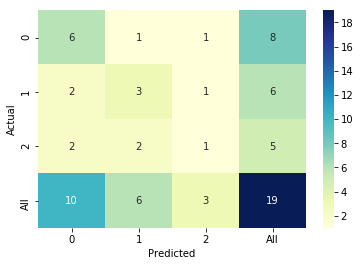

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1.5, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__subsample': 0.6}
Stride-based model performance (mean):  [0.5223405048686036, 0.5372892748512978, 0.4786552579476573, 0.4502784753378767, 0.6466810622509119]
Stride-based model performance (standard deviation):  [0.059563905964402974, 0.07126315819191308, 0.06409790373827506, 0.06905120195216782, 0.0653522555428207]
Person-based model performance (mean):  [0.5433333333333333, 0.5, 0.3555555555555555, 0.3866666666666666, 0.8]
Person-based model performance (standard deviation):  [0.19933221850301405, 0.21081851067789195, 0.29101779674908435, 0.2538980061577171, 0.17159383568311665]


<Figure size 432x288 with 0 Axes>

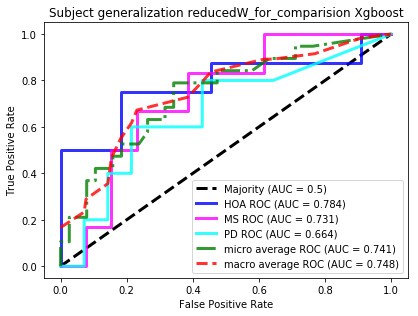

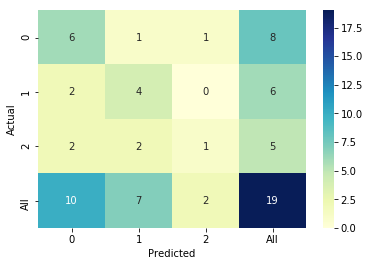

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 4}
Stride-based model performance (mean):  [0.537982132918046, 0.5039699807267404, 0.5076524164371584, 0.4692002732144589, 0.6911432142078354]
Stride-based model performance (standard deviation):  [0.058222123957441946, 0.09330169853508387, 0.07989168431548066, 0.10198684928849157, 0.09398908777570808]
Person-based model performance (mean):  [0.7366666666666666, 0.7, 0.611111111111111, 0.64, 0.8416666666666666]
Person-based model performance (standard deviation):  [0.2530700386146974, 0.26666666666666666, 0.3478327964999673, 0.32482473906879555, 0.13540064007726602]


<Figure size 432x288 with 0 Axes>

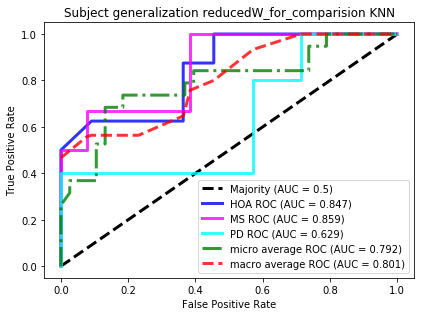

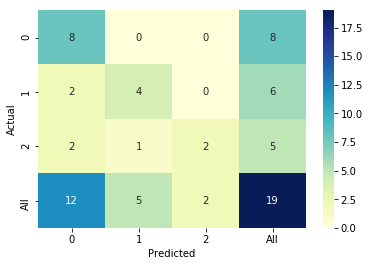

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 17}
Stride-based model performance (mean):  [0.4741336539807534, 0.4524035425395567, 0.44973413358977743, 0.41280751538037874, 0.579834806967449]
Stride-based model performance (standard deviation):  [0.052096508669841474, 0.07625147805985, 0.04523345736679352, 0.06889574586038857, 0.05870009387714748]
Person-based model performance (mean):  [0.6766666666666665, 0.6333333333333333, 0.5333333333333333, 0.5533333333333333, 0.7666666666666666]
Person-based model performance (standard deviation):  [0.2341889076033373, 0.2666666666666667, 0.3524167006034157, 0.31975299108631017, 0.17795130420052185]


<Figure size 432x288 with 0 Axes>

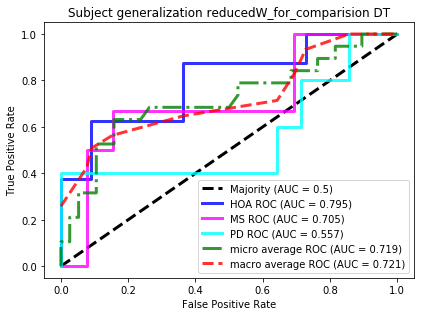

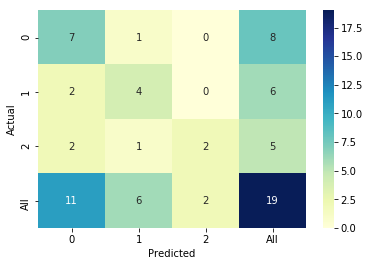

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.5553540964844451, 0.5191413374223975, 0.5248235305481477, 0.49039303201694606, 0.7009384420207682]
Stride-based model performance (standard deviation):  [0.08989238045710557, 0.1344865179709057, 0.13818679515582405, 0.14432088040884553, 0.1009460244782248]
Person-based model performance (mean):  [0.6366666666666666, 0.6, 0.5, 0.5199999999999999, 0.8333333333333333]
Person-based model performance (standard deviation):  [0.22666666666666668, 0.27080128015453203, 0.3565957007973603, 0.32183118034456404, 0.19002923751652298]


<Figure size 432x288 with 0 Axes>

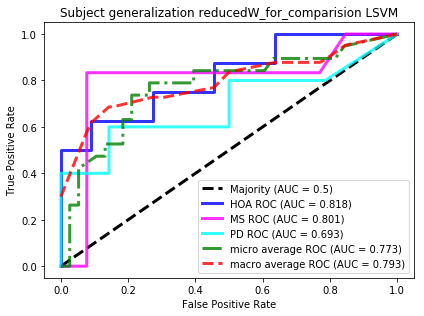

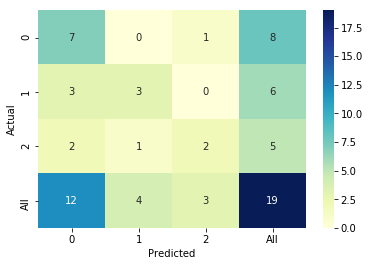

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.5382198674785401, 0.5055504154851412, 0.5058734974716257, 0.47536983589881465, 0.6920246091114772]
Stride-based model performance (standard deviation):  [0.056539852978168485, 0.1114561228703515, 0.09957485692199616, 0.1045268797701291, 0.09354515952954238]
Person-based model performance (mean):  [0.61, 0.5666666666666667, 0.4333333333333333, 0.4644444444444444, 0.8]
Person-based model performance (standard deviation):  [0.1717879830230017, 0.2, 0.26620330112690976, 0.23332275108278552, 0.17159383568311665]


<Figure size 432x288 with 0 Axes>

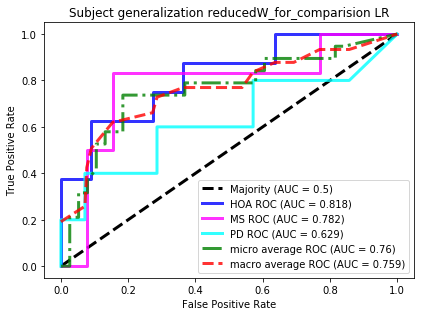

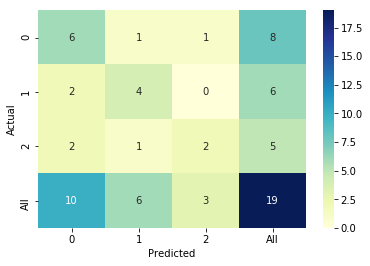

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 50, 100, 150, 100, 200)}
Stride-based model performance (mean):  [0.5361563734978512, 0.49737229169863584, 0.510830125579133, 0.47817131417235015, 0.6868940452972867]
Stride-based model performance (standard deviation):  [0.0757772023763042, 0.13499796580091872, 0.11982323428958876, 0.1199829540437772, 0.1441718910807948]
Person-based model performance (mean):  [0.61, 0.5666666666666667, 0.44444444444444436, 0.47555555555555556, 0.675]
Person-based model performance (standard deviation):  [0.1717879830230017, 0.2, 0.2533723166886973, 0.2198091203356131, 0.32532035493238554]


<Figure size 432x288 with 0 Axes>

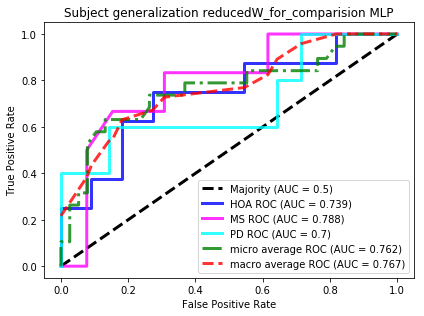

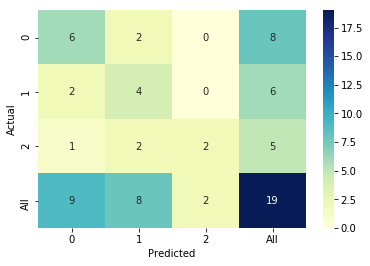

********************************


In [67]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_reducedW_for_comparision = run_ml_models(ml_models, X_reduced_data_W, Y_reduced_data_W, framework)

In [68]:
metrics_reducedW_for_comparision

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.485891  0.502631    0.548298  0.502759   
stride_mean_precision       0.526065  0.472363    0.559215  0.509464   
stride_mean_recall          0.440521  0.467409    0.508448  0.465272   
stride_mean_F1              0.396045  0.423075    0.458841  0.434640   
stride_mean_AUC             0.632721  0.572655    0.742837  0.676462   
stride_std_accuracy         0.095675  0.016659    0.041753  0.047373   
stride_std_precision        0.107311  0.076612    0.106765  0.034202   
stride_std_recall           0.053974  0.052666    0.086583  0.055255   
stride_std_F1               0.050523  0.050611    0.107445  0.059349   
stride_std_AUC              0.068506  0.106201    0.038192  0.059120   
person_mean_accuracy        0.493333  0.493333    0.610000  0.503333   
person_mean_precision       0.433333  0.433333    0.566667  0.466667   
person_mean_recall          0.277778  0.300000    0.433333  0.344444   
person_mean_F1              0.308889  0.331111    0.464444  0.366667   
person_mean_AUC             0.708333  0.725000    0.758333  0.758333   
person_std_accuracy         0.170489  0.170489    0.171788  0.160000   
person_std_precision        0.133333  0.133333    0.200000  0.194365   
person_std_recall           0.185924  0.187906    0.266203  0.284149   
person_std_F1               0.166800  0.164864    0.233323  0.239856   
person_std_AUC              0.238630  0.196497    0.167498  0.171594   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.522341  0.537982       0.474134    0.555354   
stride_mean_precision  0.537289  0.503970       0.452404    0.519141   
stride_mean_recall     0.478655  0.507652       0.449734    0.524824   
stride_mean_F1         0.450278  0.469200       0.412808    0.490393   
stride_mean_AUC        0.646681  0.691143       0.579835    0.700938   
stride_std_accuracy    0.059564  0.058222       0.052097    0.089892   
stride_std_precision   0.071263  0.093302       0.076251    0.134487   
stride_std_recall      0.064098  0.079892       0.045233    0.138187   
stride_std_F1          0.069051  0.101987       0.068896    0.144321   
stride_std_AUC         0.065352  0.093989       0.058700    0.100946   
person_mean_accuracy   0.543333  0.736667       0.676667    0.636667   
person_mean_precision  0.500000  0.700000       0.633333    0.600000   
person_mean_recall     0.355556  0.611111       0.533333    0.500000   
person_mean_F1         0.386667  0.640000       0.553333    0.520000   
person_mean_AUC        0.800000  0.841667       0.766667    0.833333   
person_std_accuracy    0.199332  0.253070       0.234189    0.226667   
person_std_precision   0.210819  0.266667       0.266667    0.270801   
person_std_recall      0.291018  0.347833       0.352417    0.356596   
person_std_F1          0.253898  0.324825       0.319753    0.321831   
person_std_AUC         0.171594  0.135401       0.177951    0.190029   

                       logistic_regression       mlp  
stride_mean_accuracy              0.538220  0.536156  
stride_mean_precision             0.505550  0.497372  
stride_mean_recall                0.505873  0.510830  
stride_mean_F1                    0.475370  0.478171  
stride_mean_AUC                   0.692025  0.686894  
stride_std_accuracy               0.056540  0.075777  
stride_std_precision              0.111456  0.134998  
stride_std_recall                 0.099575  0.119823  
stride_std_F1                     0.104527  0.119983  
stride_std_AUC                    0.093545  0.144172  
person_mean_accuracy              0.610000  0.610000  
person_mean_precision             0.566667  0.566667  
person_mean_recall                0.433333  0.444444  
person_mean_F1                    0.464444  0.475556  
person_mean_AUC                   0.800000  0.675000  
person_std_accuracy               0.171788  0.171788  
person_std_precision              0.200000  0.200000  
person_

#### Trial WT

In [69]:
#Running the traditional models again for all sub-frameworks of suject generalization to give a ranking of best to worst 
#tasks for subject generalization 

#Trial WT
reduced_data_WT = reduced_data[reduced_data.scenario=='WT'].reset_index().drop('index', axis = 1)
cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']

#Shuffling the cross validation stride data
reduced_data_WT = shuffle(reduced_data_WT, random_state = 0)
#CV for people generalize so no train-test split
X_reduced_data_WT = reduced_data_WT.drop(cols_to_drop, axis = 1)
Y_reduced_data_WT = reduced_data_WT[['PID', 'label']]

#Defining the framework of interest
framework = 'reducedWT_for_comparision'

random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 45}
Stride-based model performance (mean):  [0.4755545482424225, 0.44462477717970816, 0.41595014604867886, 0.3731149607434863, 0.5970282656899525]
Stride-based model performance (standard deviation):  [0.20845315005436124, 0.1997819027084078, 0.19089569629814007, 0.20346667053297574, 0.1723911707521044]
Person-based model performance (mean):  [0.5033333333333333, 0.4333333333333333, 0.28888888888888886, 0.3333333333333333, 0.625]
Person-based model performance (standard deviation):  [0.16, 0.13333333333333333, 0.17356110390903678, 0.16101529717988264, 0.25]


<Figure size 432x288 with 0 Axes>

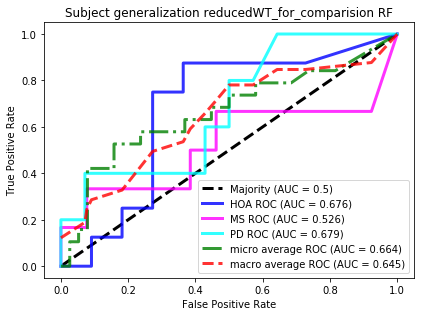

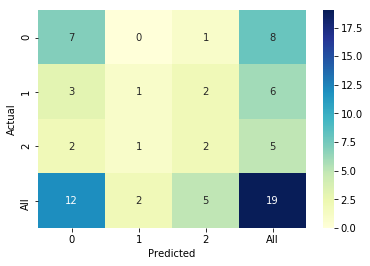

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.5252658783811341, 0.46177516035245353, 0.4701680037204089, 0.43180367653778956, 0.6218563449772383]
Stride-based model performance (standard deviation):  [0.14333298146113496, 0.17337880728030747, 0.13663704202960072, 0.14922185350183376, 0.16396395907884595]
Person-based model performance (mean):  [0.53, 0.4666666666666667, 0.3, 0.3555555555555555, 0.7083333333333334]
Person-based model performance (standard deviation):  [0.15719768163402129, 0.1632993161855452, 0.16329931618554522, 0.16329931618554516, 0.2813657169355689]


<Figure size 432x288 with 0 Axes>

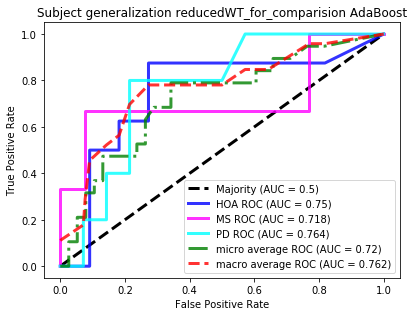

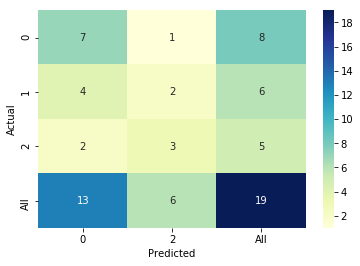

********************************
kernel_svm
best_params:  {'svc__gamma': 0.001}
Stride-based model performance (mean):  [0.45283168117012285, 0.33940743759097813, 0.38604274779717906, 0.3141149749533571, 0.5411956518927115]
Stride-based model performance (standard deviation):  [0.1392993961155467, 0.13490906889474505, 0.11450945128060863, 0.11496632040794125, 0.12213443598520525]
Person-based model performance (mean):  [0.42333333333333334, 0.36666666666666664, 0.26666666666666666, 0.28888888888888886, 0.55]
Person-based model performance (standard deviation):  [0.18903262505010432, 0.1632993161855452, 0.13333333333333336, 0.1333333333333333, 0.23481671339342286]


<Figure size 432x288 with 0 Axes>

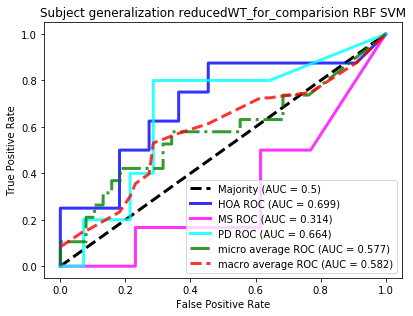

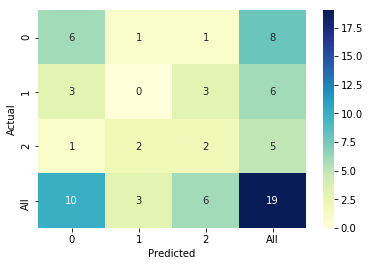

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.48385184097106215, 0.4698805672559316, 0.43981613970498534, 0.4201317224727516, 0.6080928984233945]
Stride-based model performance (standard deviation):  [0.1842799650351208, 0.17807967630378493, 0.17067809584956692, 0.17109718663063495, 0.18555395715021913]
Person-based model performance (mean):  [0.5033333333333333, 0.4333333333333333, 0.31111111111111106, 0.3533333333333333, 0.6541666666666666]
Person-based model performance (standard deviation):  [0.26465910988372277, 0.24944382578492943, 0.19751543149590198, 0.2145796925257477, 0.26339134382131846]


<Figure size 432x288 with 0 Axes>

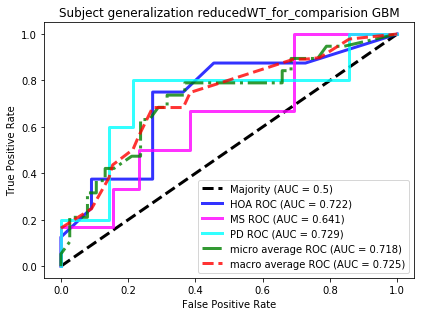

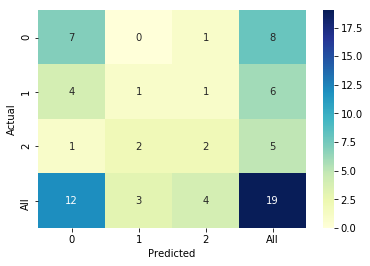

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 1.0}
Stride-based model performance (mean):  [0.497143099298407, 0.4750118629420852, 0.44646380217978204, 0.41961544432779724, 0.5650407681250711]
Stride-based model performance (standard deviation):  [0.16967801141621824, 0.17103915737221642, 0.1495286887897728, 0.14839535840922127, 0.16808178458898654]
Person-based model performance (mean):  [0.61, 0.5333333333333333, 0.37777777777777777, 0.4311111111111111, 0.7250000000000001]
Person-based model performance (standard deviation):  [0.1717879830230017, 0.1632993161855452, 0.17356110390903673, 0.17132742459907893, 0.25495097567963926]


<Figure size 432x288 with 0 Axes>

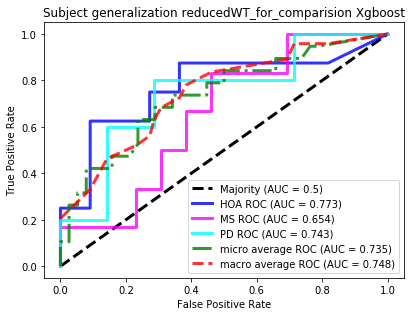

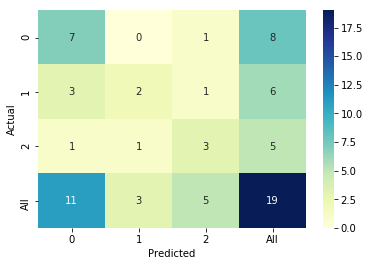

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 1}
Stride-based model performance (mean):  [0.4792522654056347, 0.4460036798936784, 0.43758221225187943, 0.41614864176757305, 0.5781866591889097]
Stride-based model performance (standard deviation):  [0.17498968594367778, 0.1913690852988725, 0.170892347661756, 0.17871545222785395, 0.12816926074631704]
Person-based model performance (mean):  [0.5933333333333334, 0.5333333333333333, 0.4, 0.44222222222222224, 0.6666666666666667]
Person-based model performance (standard deviation):  [0.265329983228432, 0.2666666666666667, 0.33957126199858056, 0.31897985539552204, 0.2173067468400883]


<Figure size 432x288 with 0 Axes>

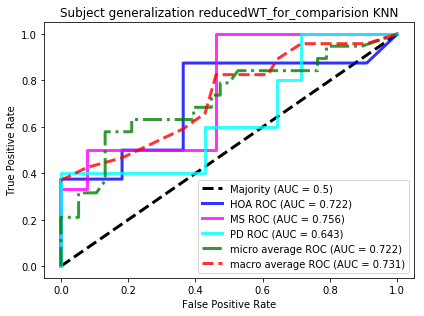

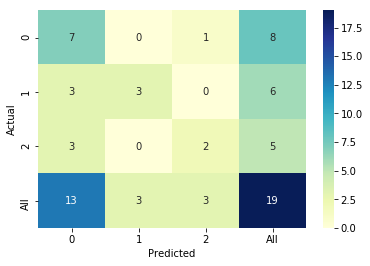

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 9}
Stride-based model performance (mean):  [0.4308120431856416, 0.4360314432072882, 0.4062835699226336, 0.4001714172072878, 0.5786142613087991]
Stride-based model performance (standard deviation):  [0.17868807339069054, 0.159081811081465, 0.17322363130308457, 0.1583718863881989, 0.1324492662387405]
Person-based model performance (mean):  [0.37, 0.3, 0.2333333333333333, 0.2444444444444444, 0.6333333333333333]
Person-based model performance (standard deviation):  [0.3124099870362662, 0.26666666666666666, 0.22607766610417562, 0.22662308949301263, 0.24494897427831783]


<Figure size 432x288 with 0 Axes>

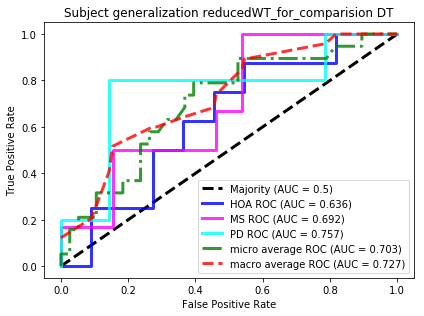

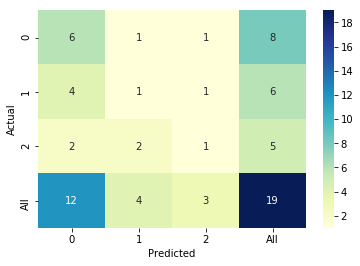

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.4537295268610671, 0.44109507727921676, 0.41470619106578777, 0.38543680723948615, 0.6036237654528203]
Stride-based model performance (standard deviation):  [0.09349805212571674, 0.07243234936963243, 0.08144953131008847, 0.09116656484829413, 0.09597657803644218]
Person-based model performance (mean):  [0.5033333333333333, 0.4333333333333333, 0.3, 0.3333333333333333, 0.6833333333333333]
Person-based model performance (standard deviation):  [0.16, 0.13333333333333333, 0.16329931618554522, 0.14054567378526128, 0.1699673171197595]


<Figure size 432x288 with 0 Axes>

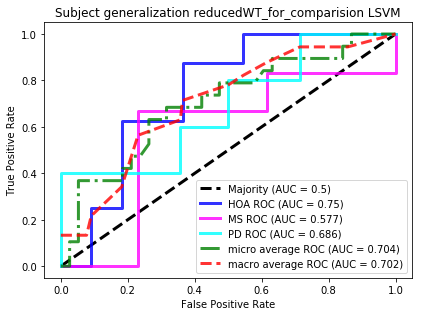

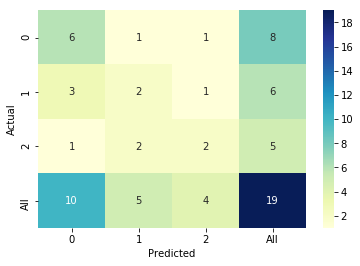

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.4601611533470572, 0.4498899632501616, 0.42693230162486434, 0.396282721223844, 0.5778624404273818]
Stride-based model performance (standard deviation):  [0.1208338358711419, 0.11333588267719358, 0.107282888019008, 0.124101171697525, 0.10957093987003093]
Person-based model performance (mean):  [0.46333333333333326, 0.39999999999999997, 0.28888888888888886, 0.31555555555555553, 0.6749999999999999]
Person-based model performance (standard deviation):  [0.1557776192739723, 0.13333333333333333, 0.1507184440694504, 0.13063945294843615, 0.22110831935702666]


<Figure size 432x288 with 0 Axes>

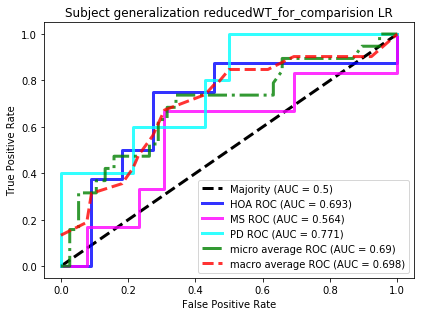

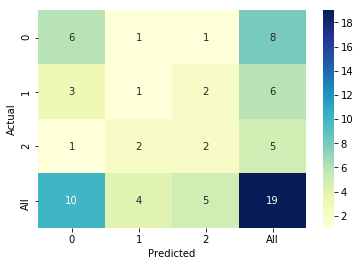

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (21, 84, 7, 7, 7, 84, 5)}
Stride-based model performance (mean):  [0.5339936561635265, 0.49922364813016606, 0.5005655522541981, 0.47967654468380605, 0.6719663465151057]
Stride-based model performance (standard deviation):  [0.12088746344576999, 0.13279133710766164, 0.1261340505044302, 0.14126813717997572, 0.1321398914556018]
Person-based model performance (mean):  [0.67, 0.6333333333333333, 0.5444444444444445, 0.5755555555555556, 0.7166666666666667]
Person-based model performance (standard deviation):  [0.21612753436596438, 0.22110831935702666, 0.26620330112690976, 0.2496812783144558, 0.19436506316151]


<Figure size 432x288 with 0 Axes>

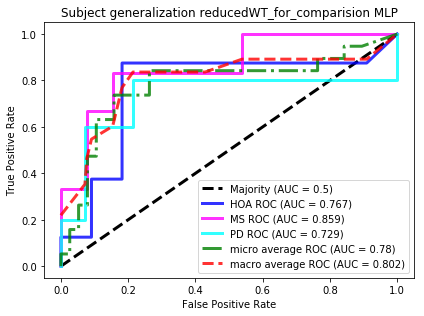

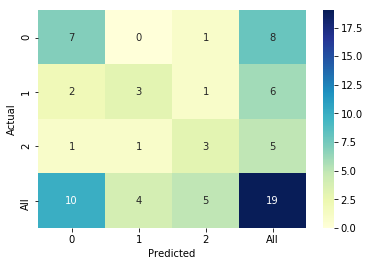

********************************


In [70]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_reducedWT_for_comparision = run_ml_models(ml_models, X_reduced_data_WT, Y_reduced_data_WT, framework)

In [71]:
metrics_reducedWT_for_comparision

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.475555  0.525266    0.452832  0.483852   
stride_mean_precision       0.444625  0.461775    0.339407  0.469881   
stride_mean_recall          0.415950  0.470168    0.386043  0.439816   
stride_mean_F1              0.373115  0.431804    0.314115  0.420132   
stride_mean_AUC             0.597028  0.621856    0.541196  0.608093   
stride_std_accuracy         0.208453  0.143333    0.139299  0.184280   
stride_std_precision        0.199782  0.173379    0.134909  0.178080   
stride_std_recall           0.190896  0.136637    0.114509  0.170678   
stride_std_F1               0.203467  0.149222    0.114966  0.171097   
stride_std_AUC              0.172391  0.163964    0.122134  0.185554   
person_mean_accuracy        0.503333  0.530000    0.423333  0.503333   
person_mean_precision       0.433333  0.466667    0.366667  0.433333   
person_mean_recall          0.288889  0.300000    0.266667  0.311111   
person_mean_F1              0.333333  0.355556    0.288889  0.353333   
person_mean_AUC             0.625000  0.708333    0.550000  0.654167   
person_std_accuracy         0.160000  0.157198    0.189033  0.264659   
person_std_precision        0.133333  0.163299    0.163299  0.249444   
person_std_recall           0.173561  0.163299    0.133333  0.197515   
person_std_F1               0.161015  0.163299    0.133333  0.214580   
person_std_AUC              0.250000  0.281366    0.234817  0.263391   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.497143  0.479252       0.430812    0.453730   
stride_mean_precision  0.475012  0.446004       0.436031    0.441095   
stride_mean_recall     0.446464  0.437582       0.406284    0.414706   
stride_mean_F1         0.419615  0.416149       0.400171    0.385437   
stride_mean_AUC        0.565041  0.578187       0.578614    0.603624   
stride_std_accuracy    0.169678  0.174990       0.178688    0.093498   
stride_std_precision   0.171039  0.191369       0.159082    0.072432   
stride_std_recall      0.149529  0.170892       0.173224    0.081450   
stride_std_F1          0.148395  0.178715       0.158372    0.091167   
stride_std_AUC         0.168082  0.128169       0.132449    0.095977   
person_mean_accuracy   0.610000  0.593333       0.370000    0.503333   
person_mean_precision  0.533333  0.533333       0.300000    0.433333   
person_mean_recall     0.377778  0.400000       0.233333    0.300000   
person_mean_F1         0.431111  0.442222       0.244444    0.333333   
person_mean_AUC        0.725000  0.666667       0.633333    0.683333   
person_std_accuracy    0.171788  0.265330       0.312410    0.160000   
person_std_precision   0.163299  0.266667       0.266667    0.133333   
person_std_recall      0.173561  0.339571       0.226078    0.163299   
person_std_F1          0.171327  0.318980       0.226623    0.140546   
person_std_AUC         0.254951  0.217307       0.244949    0.169967   

                       logistic_regression       mlp  
stride_mean_accuracy              0.460161  0.533994  
stride_mean_precision             0.449890  0.499224  
stride_mean_recall                0.426932  0.500566  
stride_mean_F1                    0.396283  0.479677  
stride_mean_AUC                   0.577862  0.671966  
stride_std_accuracy               0.120834  0.120887  
stride_std_precision              0.113336  0.132791  
stride_std_recall                 0.107283  0.126134  
stride_std_F1                     0.124101  0.141268  
stride_std_AUC                    0.109571  0.132140  
person_mean_accuracy              0.463333  0.670000  
person_mean_precision             0.400000  0.633333  
person_mean_recall                0.288889  0.544444  
person_mean_F1                    0.315556  0.575556  
person_mean_AUC                   0.675000  0.716667  
person_std_accuracy               0.155778  0.216128  
person_std_precision              0.133333  0.221108  
person_

#### Trial VBW

In [72]:
#Running the traditional models again for all sub-frameworks of suject generalization to give a ranking of best to worst 
#tasks for subject generalization 

#Trial VBW
reduced_data_VBW = reduced_data[reduced_data.scenario=='SLW'].reset_index().drop('index', axis = 1)
cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']

#Shuffling the cross validation stride data
reduced_data_VBW = shuffle(reduced_data_VBW, random_state = 0)
#CV for people generalize so no train-test split
X_reduced_data_VBW = reduced_data_VBW.drop(cols_to_drop, axis = 1)
Y_reduced_data_VBW = reduced_data_VBW[['PID', 'label']]

#Defining the framework of interest
framework = 'reducedVBW_for_comparision'

random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 40}
Stride-based model performance (mean):  [0.49295718704234215, 0.41113900676052173, 0.44158361274249336, 0.4009682067807298, 0.6125691068488066]
Stride-based model performance (standard deviation):  [0.10711818031140034, 0.09860044002077677, 0.0688409866139636, 0.07077660967760946, 0.10225734202032258]
Person-based model performance (mean):  [0.5166666666666666, 0.5, 0.36111111111111105, 0.3911111111111111, 0.7166666666666667]
Person-based model performance (standard deviation):  [0.20682789409984761, 0.14907119849998596, 0.19563129846287786, 0.18357223491611893, 0.17950549357115014]


<Figure size 432x288 with 0 Axes>

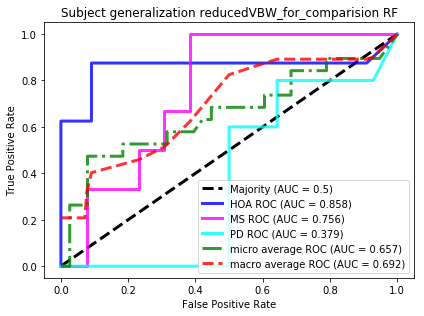

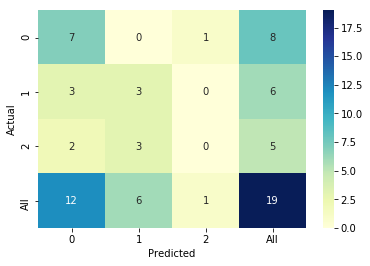

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.5382876207477348, 0.47933479066799345, 0.4760915627498415, 0.44853482838907377, 0.6120158984715836]
Stride-based model performance (standard deviation):  [0.08273741315665041, 0.07619981671368013, 0.055317618609954905, 0.07757374439030287, 0.07018157606902627]
Person-based model performance (mean):  [0.4833333333333333, 0.4333333333333333, 0.29444444444444445, 0.3355555555555555, 0.7833333333333334]
Person-based model performance (standard deviation):  [0.13333333333333333, 0.13333333333333333, 0.17356110390903678, 0.16366180124019525, 0.13540064007726602]


<Figure size 432x288 with 0 Axes>

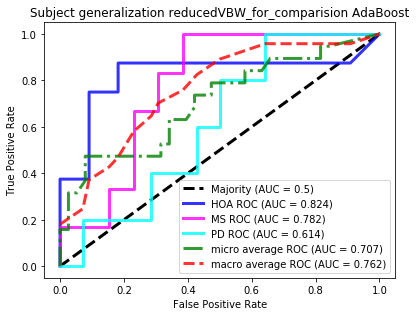

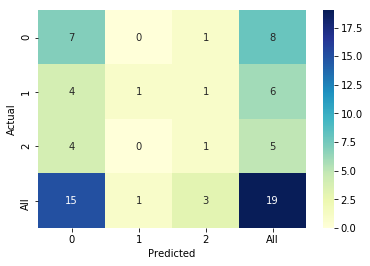

********************************
kernel_svm
best_params:  {'svc__gamma': 1}
Stride-based model performance (mean):  [0.45773467660446476, 0.15257822553482156, 0.3333333333333333, 0.2075666504437347, 0.38256572973846603]
Stride-based model performance (standard deviation):  [0.0898936495600913, 0.02996454985336376, 0.0, 0.02870728361469786, 0.06315237498165856]
Person-based model performance (mean):  [0.41666666666666663, 0.3333333333333333, 0.1388888888888889, 0.1933333333333333, 0.5]
Person-based model performance (standard deviation):  [0.10540925533894598, 0.0, 0.03513641844631532, 0.036918328279635884, 0.0]


<Figure size 432x288 with 0 Axes>

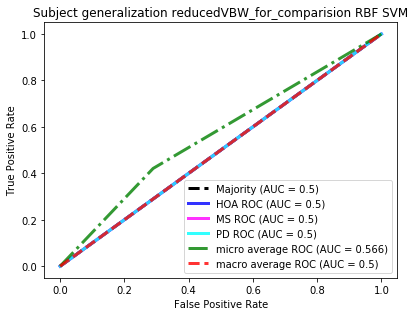

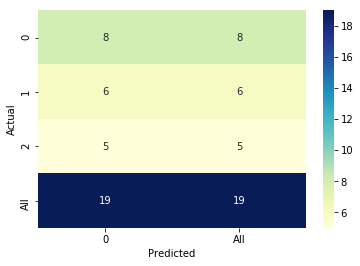

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.15, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 100}
Stride-based model performance (mean):  [0.5324645775428497, 0.4800221542313784, 0.465358021542322, 0.44473192294302394, 0.6702310679213611]
Stride-based model performance (standard deviation):  [0.08934074978845437, 0.08991518790548957, 0.06466382738679516, 0.07038008620078827, 0.09845347296278757]
Person-based model performance (mean):  [0.55, 0.5, 0.41111111111111115, 0.44222222222222224, 0.8]
Person-based model performance (standard deviation):  [0.2449489742783178, 0.25819888974716115, 0.3193357302933314, 0.2973462877098263, 0.17159383568311665]


<Figure size 432x288 with 0 Axes>

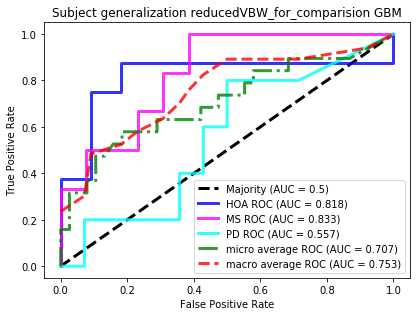

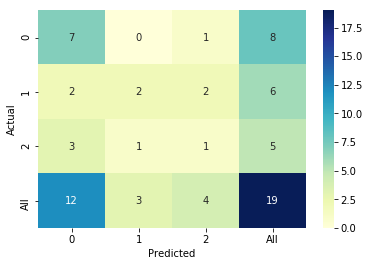

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 1.0}
Stride-based model performance (mean):  [0.5299682930361268, 0.47644519414422737, 0.4712428365900421, 0.445773057076342, 0.6731757880117037]
Stride-based model performance (standard deviation):  [0.10594355064393048, 0.11337046465030784, 0.0665708937574565, 0.06488783087015072, 0.08679384107242616]
Person-based model performance (mean):  [0.5666666666666667, 0.5333333333333333, 0.4111111111111111, 0.4533333333333333, 0.7416666666666667]
Person-based model performance (standard deviation):  [0.16158932858054434, 0.12472191289246472, 0.14315665251916804, 0.13542799097948968, 0.1404358295529393]


<Figure size 432x288 with 0 Axes>

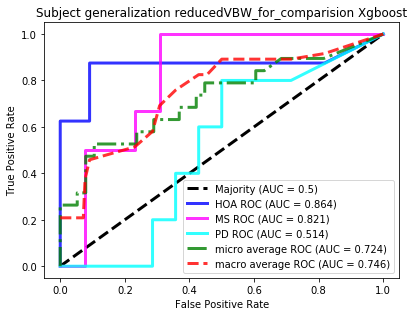

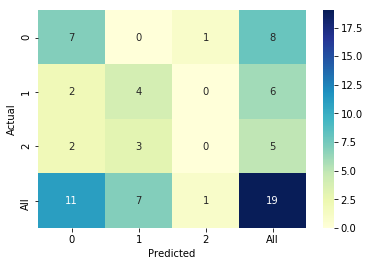

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 1}
Stride-based model performance (mean):  [0.5326638290494896, 0.44618273933157526, 0.45419550051635005, 0.4240799263735123, 0.6303824257056698]
Stride-based model performance (standard deviation):  [0.13595614374721196, 0.1364448739950822, 0.1376744737581735, 0.14533190704252646, 0.11504977048399659]
Person-based model performance (mean):  [0.6, 0.5666666666666667, 0.4666666666666666, 0.49777777777777776, 0.7833333333333334]
Person-based model performance (standard deviation):  [0.25495097567963926, 0.24944382578492946, 0.3193357302933314, 0.2994150676169277, 0.13540064007726602]


<Figure size 432x288 with 0 Axes>

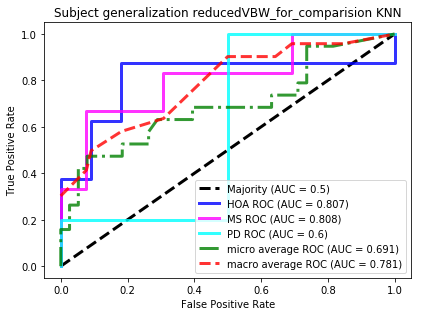

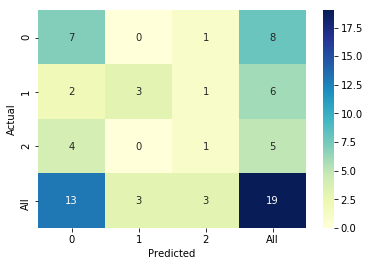

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 45}
Stride-based model performance (mean):  [0.4503931816035318, 0.38108590330071423, 0.38977677139776046, 0.35826324091142986, 0.5953360069298211]
Stride-based model performance (standard deviation):  [0.09647112823759754, 0.082576167049836, 0.051736879842542764, 0.05717471277151001, 0.10988175561806836]
Person-based model performance (mean):  [0.41666666666666663, 0.3666666666666666, 0.2444444444444444, 0.27555555555555555, 0.5666666666666667]
Person-based model performance (standard deviation):  [0.10540925533894598, 0.06666666666666668, 0.12957670877434002, 0.08618097524295695, 0.23213980461973532]


<Figure size 432x288 with 0 Axes>

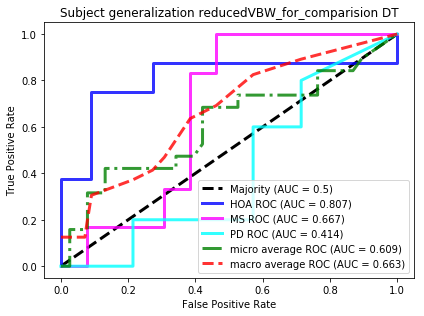

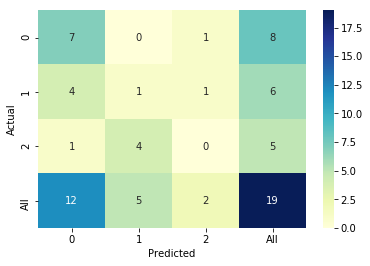

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.4520587004785314, 0.345502853147326, 0.37538405446827333, 0.35188490468319333, 0.5034918762819597]
Stride-based model performance (standard deviation):  [0.06295742602158554, 0.05413560146217934, 0.04223899762280844, 0.04718645074570071, 0.07410731425393485]
Person-based model performance (mean):  [0.5333333333333333, 0.4666666666666666, 0.34444444444444444, 0.3866666666666666, 0.5]
Person-based model performance (standard deviation):  [0.06666666666666667, 0.12472191289246472, 0.13788526273323176, 0.12869717542729117, 0.0912870929175277]


<Figure size 432x288 with 0 Axes>

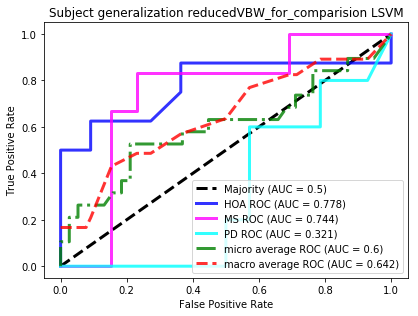

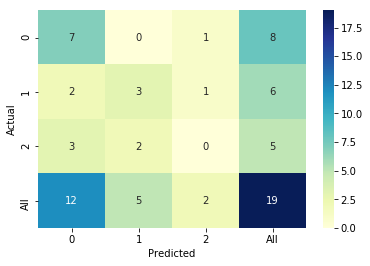

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.46267726067877135, 0.360784572000419, 0.3851327806496663, 0.3594709384643767, 0.49177776927696437]
Stride-based model performance (standard deviation):  [0.060415606355742085, 0.043569019061138366, 0.03854849202531545, 0.03645665769567539, 0.05439256797462646]
Person-based model performance (mean):  [0.5333333333333333, 0.4666666666666666, 0.34444444444444444, 0.3866666666666666, 0.5833333333333333]
Person-based model performance (standard deviation):  [0.06666666666666667, 0.12472191289246472, 0.13788526273323176, 0.12869717542729117, 0.07453559924999298]


<Figure size 432x288 with 0 Axes>

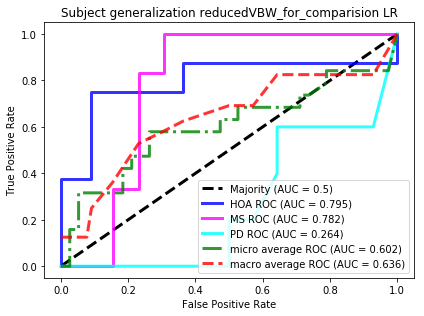

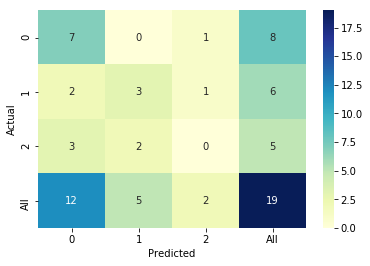

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 50, 50, 5, 30, 50, 20)}
Stride-based model performance (mean):  [0.5298499720809869, 0.4979884958871884, 0.48104435111726174, 0.47089803590142126, 0.7067489397764908]
Stride-based model performance (standard deviation):  [0.07595560067307575, 0.05310904135760739, 0.05631867138844994, 0.043791437138221624, 0.06481738151290402]
Person-based model performance (mean):  [0.5833333333333333, 0.5333333333333333, 0.4666666666666667, 0.4666666666666666, 0.7333333333333334]
Person-based model performance (standard deviation):  [0.10540925533894598, 0.12472191289246472, 0.06666666666666668, 0.08314794192830978, 0.13333333333333336]


<Figure size 432x288 with 0 Axes>

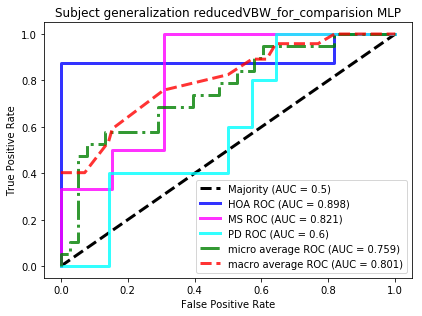

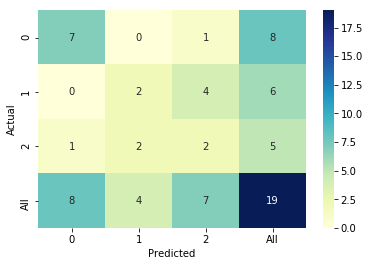

********************************


In [73]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_reducedVBW_for_comparision = run_ml_models(ml_models, X_reduced_data_VBW, Y_reduced_data_VBW, framework)

In [74]:
metrics_reducedVBW_for_comparision

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.492957  0.538288    0.457735  0.532465   
stride_mean_precision       0.411139  0.479335    0.152578  0.480022   
stride_mean_recall          0.441584  0.476092    0.333333  0.465358   
stride_mean_F1              0.400968  0.448535    0.207567  0.444732   
stride_mean_AUC             0.612569  0.612016    0.382566  0.670231   
stride_std_accuracy         0.107118  0.082737    0.089894  0.089341   
stride_std_precision        0.098600  0.076200    0.029965  0.089915   
stride_std_recall           0.068841  0.055318    0.000000  0.064664   
stride_std_F1               0.070777  0.077574    0.028707  0.070380   
stride_std_AUC              0.102257  0.070182    0.063152  0.098453   
person_mean_accuracy        0.516667  0.483333    0.416667  0.550000   
person_mean_precision       0.500000  0.433333    0.333333  0.500000   
person_mean_recall          0.361111  0.294444    0.138889  0.411111   
person_mean_F1              0.391111  0.335556    0.193333  0.442222   
person_mean_AUC             0.716667  0.783333    0.500000  0.800000   
person_std_accuracy         0.206828  0.133333    0.105409  0.244949   
person_std_precision        0.149071  0.133333    0.000000  0.258199   
person_std_recall           0.195631  0.173561    0.035136  0.319336   
person_std_F1               0.183572  0.163662    0.036918  0.297346   
person_std_AUC              0.179505  0.135401    0.000000  0.171594   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.529968  0.532664       0.450393    0.452059   
stride_mean_precision  0.476445  0.446183       0.381086    0.345503   
stride_mean_recall     0.471243  0.454196       0.389777    0.375384   
stride_mean_F1         0.445773  0.424080       0.358263    0.351885   
stride_mean_AUC        0.673176  0.630382       0.595336    0.503492   
stride_std_accuracy    0.105944  0.135956       0.096471    0.062957   
stride_std_precision   0.113370  0.136445       0.082576    0.054136   
stride_std_recall      0.066571  0.137674       0.051737    0.042239   
stride_std_F1          0.064888  0.145332       0.057175    0.047186   
stride_std_AUC         0.086794  0.115050       0.109882    0.074107   
person_mean_accuracy   0.566667  0.600000       0.416667    0.533333   
person_mean_precision  0.533333  0.566667       0.366667    0.466667   
person_mean_recall     0.411111  0.466667       0.244444    0.344444   
person_mean_F1         0.453333  0.497778       0.275556    0.386667   
person_mean_AUC        0.741667  0.783333       0.566667    0.500000   
person_std_accuracy    0.161589  0.254951       0.105409    0.066667   
person_std_precision   0.124722  0.249444       0.066667    0.124722   
person_std_recall      0.143157  0.319336       0.129577    0.137885   
person_std_F1          0.135428  0.299415       0.086181    0.128697   
person_std_AUC         0.140436  0.135401       0.232140    0.091287   

                       logistic_regression       mlp  
stride_mean_accuracy              0.462677  0.529850  
stride_mean_precision             0.360785  0.497988  
stride_mean_recall                0.385133  0.481044  
stride_mean_F1                    0.359471  0.470898  
stride_mean_AUC                   0.491778  0.706749  
stride_std_accuracy               0.060416  0.075956  
stride_std_precision              0.043569  0.053109  
stride_std_recall                 0.038548  0.056319  
stride_std_F1                     0.036457  0.043791  
stride_std_AUC                    0.054393  0.064817  
person_mean_accuracy              0.533333  0.583333  
person_mean_precision             0.466667  0.533333  
person_mean_recall                0.344444  0.466667  
person_mean_F1                    0.386667  0.466667  
person_mean_AUC                   0.583333  0.733333  
person_std_accuracy               0.066667  0.105409  
person_std_precision              0.124722  0.124722  
person_

#### Trial VBWT

In [75]:
#Running the traditional models again for all sub-frameworks of suject generalization to give a ranking of best to worst 
#tasks for subject generalization 

#Trial VBWT
reduced_data_VBWT = reduced_data[reduced_data.scenario=='SLWT'].reset_index().drop('index', axis = 1)
cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']

#Shuffling the cross validation stride data
reduced_data_VBWT = shuffle(reduced_data_VBWT, random_state = 0)
#CV for people generalize so no train-test split
X_reduced_data_VBWT = reduced_data_VBWT.drop(cols_to_drop, axis = 1)
Y_reduced_data_VBWT = reduced_data_VBWT[['PID', 'label']]

#Defining the framework of interest
framework = 'reducedVBWT_for_comparision'

random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 0.05, 'randomforestclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.4640960245661164, 0.49112124707884847, 0.449090205145415, 0.4380350087515298, 0.6599939476474315]
Stride-based model performance (standard deviation):  [0.10742931984219842, 0.13639302125101258, 0.12056915710280466, 0.09761521754057544, 0.14542169506439384]
Person-based model performance (mean):  [0.4833333333333333, 0.4333333333333333, 0.3888888888888889, 0.37777777777777777, 0.6666666666666667]
Person-based model performance (standard deviation):  [0.2068278940998476, 0.22607766610417557, 0.12668615834434865, 0.16254154264808657, 0.2173067468400883]


<Figure size 432x288 with 0 Axes>

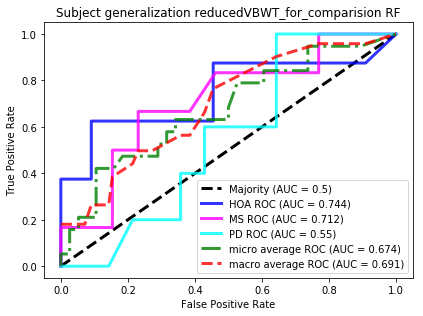

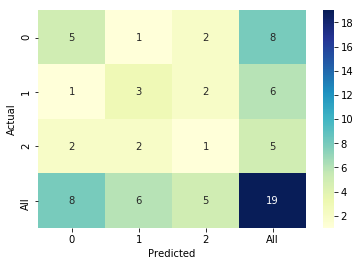

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.5185038490009763, 0.5123902913404865, 0.47944599920751363, 0.4659741301197388, 0.6781851018072613]
Stride-based model performance (standard deviation):  [0.2036264005695909, 0.1658571944043567, 0.2038623856403892, 0.20342483268614153, 0.16649631348098143]
Person-based model performance (mean):  [0.6166666666666666, 0.6, 0.5555555555555556, 0.5555555555555556, 0.6749999999999999]
Person-based model performance (standard deviation):  [0.3231786571610887, 0.3431876713662334, 0.376796110173626, 0.3701851388657263, 0.291547594742265]


<Figure size 432x288 with 0 Axes>

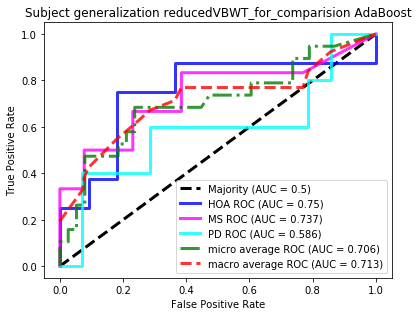

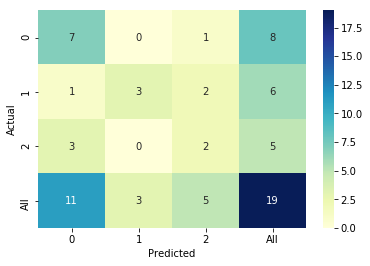

********************************
kernel_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.45727072521962536, 0.28456656447189044, 0.3443500643500644, 0.226459918977057, 0.6164610597934452]
Stride-based model performance (standard deviation):  [0.0927895973156929, 0.18471052349976302, 0.014522850085976192, 0.050532744053864015, 0.14519639365725298]
Person-based model performance (mean):  [0.41666666666666663, 0.3333333333333333, 0.1388888888888889, 0.1933333333333333, 0.6]
Person-based model performance (standard deviation):  [0.10540925533894598, 0.0, 0.03513641844631533, 0.036918328279635884, 0.1224744871391589]


<Figure size 432x288 with 0 Axes>

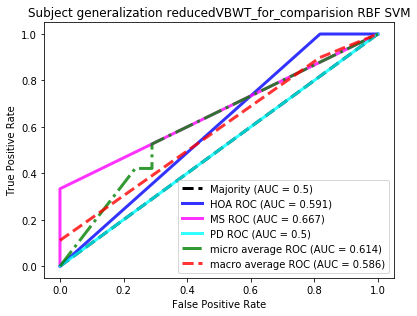

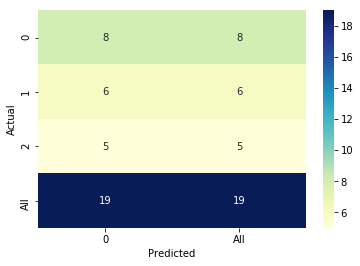

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.4800980265127001, 0.4577361558942628, 0.4496802669557397, 0.4237815328925222, 0.6660127534149188]
Stride-based model performance (standard deviation):  [0.15074053411688945, 0.15607291772312143, 0.13976687132392182, 0.15125603933849094, 0.16932511082885318]
Person-based model performance (mean):  [0.5666666666666667, 0.5666666666666667, 0.4444444444444445, 0.47777777777777775, 0.7000000000000001]
Person-based model performance (standard deviation):  [0.2758824226207808, 0.24944382578492943, 0.32773069341672506, 0.3075189445132899, 0.2273030282830976]


<Figure size 432x288 with 0 Axes>

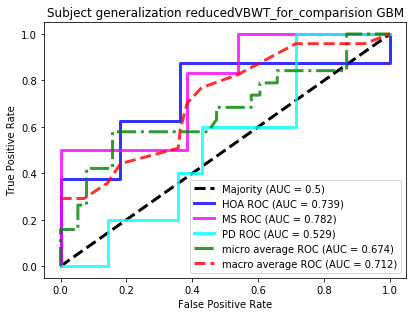

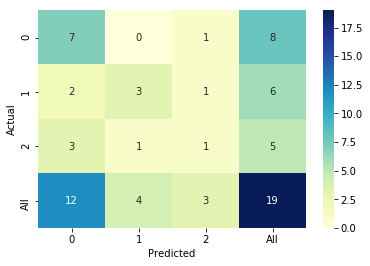

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 1.0}
Stride-based model performance (mean):  [0.47765766440020896, 0.48051799835994313, 0.45169924751598584, 0.41719404259822956, 0.650376332420884]
Stride-based model performance (standard deviation):  [0.12736326944603085, 0.12754098762099084, 0.11260650239023036, 0.11500125422677564, 0.14111402505347392]
Person-based model performance (mean):  [0.4666666666666666, 0.4666666666666667, 0.3111111111111111, 0.3555555555555555, 0.7333333333333334]
Person-based model performance (standard deviation):  [0.17159383568311667, 0.1247219128924647, 0.17427096823731247, 0.1632993161855452, 0.20682789409984761]


<Figure size 432x288 with 0 Axes>

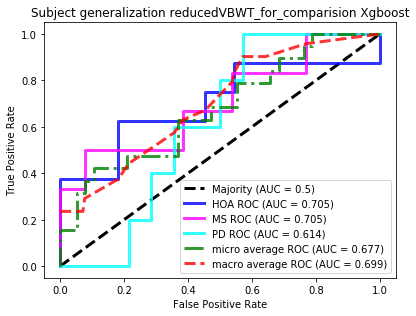

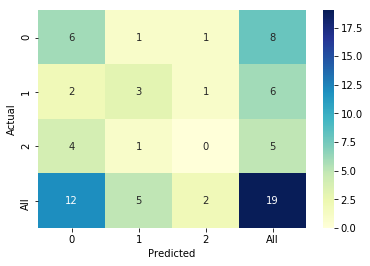

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__p': 1}
Stride-based model performance (mean):  [0.4767312115348889, 0.4248923369095783, 0.44976537566326674, 0.4132284317854892, 0.6210958054933443]
Stride-based model performance (standard deviation):  [0.13627026318509924, 0.15297519174428287, 0.139170028648712, 0.1590325540259847, 0.11776005025839269]
Person-based model performance (mean):  [0.4666666666666666, 0.4666666666666666, 0.3888888888888889, 0.4111111111111111, 0.675]
Person-based model performance (standard deviation):  [0.3231786571610887, 0.3231786571610887, 0.35136418446315326, 0.34174569998288223, 0.1674979270186815]


<Figure size 432x288 with 0 Axes>

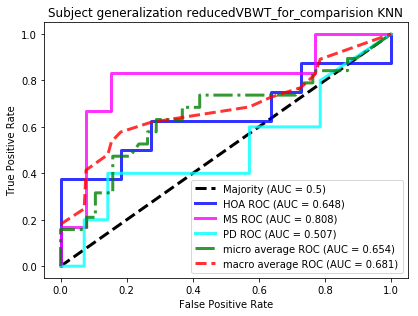

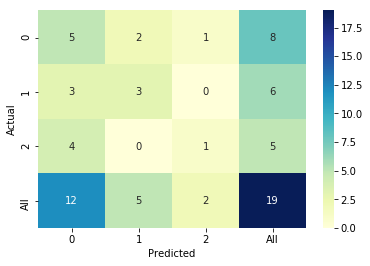

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 16}
Stride-based model performance (mean):  [0.47042451054523227, 0.46491472769600345, 0.4559272509588609, 0.4438811271084271, 0.5961135925271767]
Stride-based model performance (standard deviation):  [0.13230493494373172, 0.12523423661255334, 0.1288748602656599, 0.125038494886969, 0.09020769995435521]
Person-based model performance (mean):  [0.5833333333333333, 0.5666666666666667, 0.5666666666666667, 0.5444444444444445, 0.6500000000000001]
Person-based model performance (standard deviation):  [0.24720661623652207, 0.27080128015453203, 0.22607766610417562, 0.25434495871687995, 0.27080128015453203]


<Figure size 432x288 with 0 Axes>

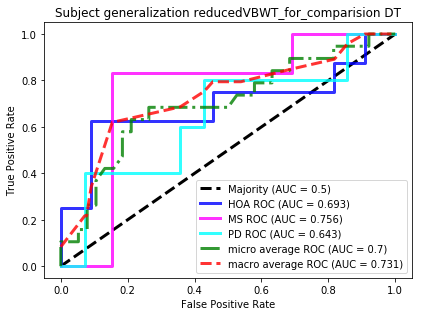

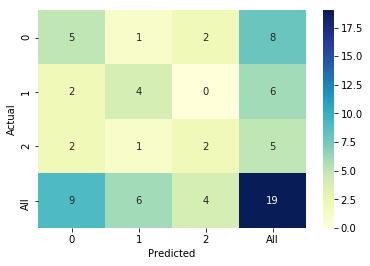

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.42197458934854665, 0.3789950965932262, 0.39007459027873737, 0.3459578645708338, 0.5864410965438905]
Stride-based model performance (standard deviation):  [0.11153993189462195, 0.11998802981372211, 0.09043931756585027, 0.0902490227749525, 0.14892087213395036]
Person-based model performance (mean):  [0.4666666666666666, 0.4666666666666667, 0.3, 0.35333333333333333, 0.6]
Person-based model performance (standard deviation):  [0.17159383568311667, 0.1247219128924647, 0.15555555555555553, 0.15192590786788632, 0.21343747458109494]


<Figure size 432x288 with 0 Axes>

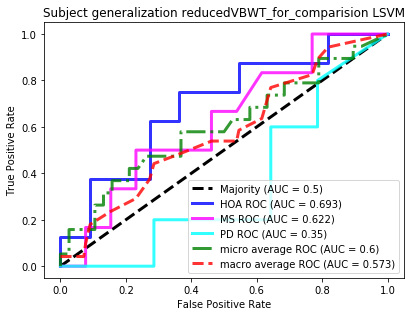

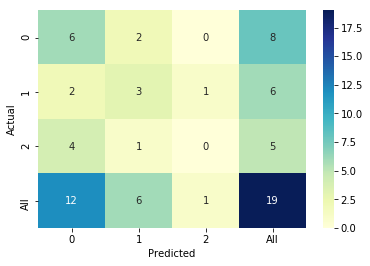

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.4361607176218037, 0.41007603768495093, 0.4001731508747226, 0.3624952880629521, 0.5836578448808765]
Stride-based model performance (standard deviation):  [0.1267970401474599, 0.13557664848234355, 0.10789386537901897, 0.10451752276911809, 0.14018093142848662]
Person-based model performance (mean):  [0.41666666666666663, 0.39999999999999997, 0.2666666666666667, 0.29777777777777775, 0.6666666666666667]
Person-based model performance (standard deviation):  [0.10540925533894598, 0.08164965809277261, 0.13788526273323173, 0.10361371757222013, 0.25276251480171835]


<Figure size 432x288 with 0 Axes>

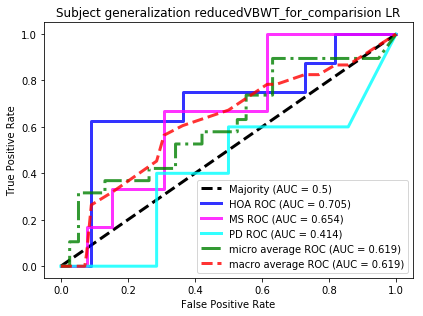

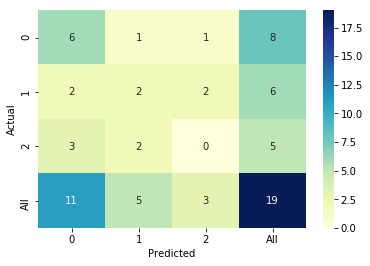

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (5, 5, 5, 5, 5, 100, 20, 100, 30, 30)}
Stride-based model performance (mean):  [0.4789015757928925, 0.457023600896637, 0.44452465195950863, 0.43531233074062436, 0.6228990793486083]
Stride-based model performance (standard deviation):  [0.0946735269402103, 0.06650695464568507, 0.08904392933836498, 0.08004160521183891, 0.07880324878084712]
Person-based model performance (mean):  [0.5333333333333333, 0.5, 0.4444444444444445, 0.42222222222222217, 0.6250000000000001]
Person-based model performance (standard deviation):  [0.06666666666666667, 0.10540925533894598, 0.060858061945018464, 0.07535922203472518, 0.2041241452319315]


<Figure size 432x288 with 0 Axes>

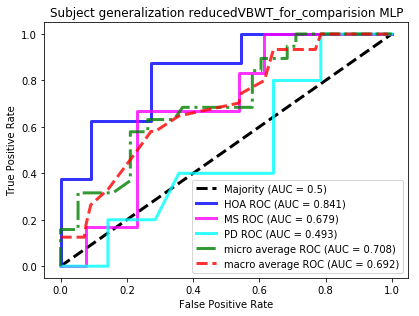

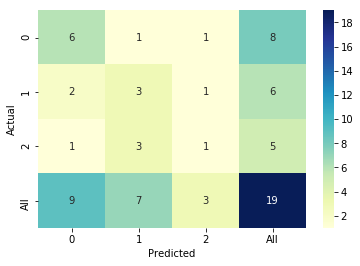

********************************


In [76]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_reducedVBWT_for_comparision = run_ml_models(ml_models, X_reduced_data_VBWT, Y_reduced_data_VBWT, framework)

In [77]:
metrics_reducedVBWT_for_comparision

random_forest  adaboost  kernel_svm       gbm  \
stride_mean_accuracy        0.464096  0.518504    0.457271  0.480098   
stride_mean_precision       0.491121  0.512390    0.284567  0.457736   
stride_mean_recall          0.449090  0.479446    0.344350  0.449680   
stride_mean_F1              0.438035  0.465974    0.226460  0.423782   
stride_mean_AUC             0.659994  0.678185    0.616461  0.666013   
stride_std_accuracy         0.107429  0.203626    0.092790  0.150741   
stride_std_precision        0.136393  0.165857    0.184711  0.156073   
stride_std_recall           0.120569  0.203862    0.014523  0.139767   
stride_std_F1               0.097615  0.203425    0.050533  0.151256   
stride_std_AUC              0.145422  0.166496    0.145196  0.169325   
person_mean_accuracy        0.483333  0.616667    0.416667  0.566667   
person_mean_precision       0.433333  0.600000    0.333333  0.566667   
person_mean_recall          0.388889  0.555556    0.138889  0.444444   
person_mean_F1              0.377778  0.555556    0.193333  0.477778   
person_mean_AUC             0.666667  0.675000    0.600000  0.700000   
person_std_accuracy         0.206828  0.323179    0.105409  0.275882   
person_std_precision        0.226078  0.343188    0.000000  0.249444   
person_std_recall           0.126686  0.376796    0.035136  0.327731   
person_std_F1               0.162542  0.370185    0.036918  0.307519   
person_std_AUC              0.217307  0.291548    0.122474  0.227303   

                        xgboost       knn  decision_tree  linear_svm  \
stride_mean_accuracy   0.477658  0.476731       0.470425    0.421975   
stride_mean_precision  0.480518  0.424892       0.464915    0.378995   
stride_mean_recall     0.451699  0.449765       0.455927    0.390075   
stride_mean_F1         0.417194  0.413228       0.443881    0.345958   
stride_mean_AUC        0.650376  0.621096       0.596114    0.586441   
stride_std_accuracy    0.127363  0.136270       0.132305    0.111540   
stride_std_precision   0.127541  0.152975       0.125234    0.119988   
stride_std_recall      0.112607  0.139170       0.128875    0.090439   
stride_std_F1          0.115001  0.159033       0.125038    0.090249   
stride_std_AUC         0.141114  0.117760       0.090208    0.148921   
person_mean_accuracy   0.466667  0.466667       0.583333    0.466667   
person_mean_precision  0.466667  0.466667       0.566667    0.466667   
person_mean_recall     0.311111  0.388889       0.566667    0.300000   
person_mean_F1         0.355556  0.411111       0.544444    0.353333   
person_mean_AUC        0.733333  0.675000       0.650000    0.600000   
person_std_accuracy    0.171594  0.323179       0.247207    0.171594   
person_std_precision   0.124722  0.323179       0.270801    0.124722   
person_std_recall      0.174271  0.351364       0.226078    0.155556   
person_std_F1          0.163299  0.341746       0.254345    0.151926   
person_std_AUC         0.206828  0.167498       0.270801    0.213437   

                       logistic_regression       mlp  
stride_mean_accuracy              0.436161  0.478902  
stride_mean_precision             0.410076  0.457024  
stride_mean_recall                0.400173  0.444525  
stride_mean_F1                    0.362495  0.435312  
stride_mean_AUC                   0.583658  0.622899  
stride_std_accuracy               0.126797  0.094674  
stride_std_precision              0.135577  0.066507  
stride_std_recall                 0.107894  0.089044  
stride_std_F1                     0.104518  0.080042  
stride_std_AUC                    0.140181  0.078803  
person_mean_accuracy              0.416667  0.533333  
person_mean_precision             0.400000  0.500000  
person_mean_recall                0.266667  0.444444  
person_mean_F1                    0.297778  0.422222  
person_mean_AUC                   0.666667  0.625000  
person_std_accuracy               0.105409  0.066667  
person_std_precision              0.081650  0.105409  
person_